In [1]:
import os
from config import query_directory, TABLES, DB_CONFIG, connect_to_db
from typing import List, Dict, Tuple
from file_utils import read_queries_from_directory, write_query_results_to_file
import pandas as pd
from tqdm import tqdm
from sql_parser import parse_sql
from query_template import get_query_template
from collections import defaultdict
import networkx as nx
import pandas as pd
from sql_parser import parse_sql
import matplotlib.pyplot as plt
from sql_parser import parse_sql

In [4]:
from pathlib import Path
try:
    # Works when running from a .py file
    REPO_ROOT = Path(__file__).resolve()
except NameError:
    # Fallback for notebooks — use current working directory
    REPO_ROOT = Path.cwd().resolve()
while REPO_ROOT.name != "Learned-Optimizers-Benchmarking-Suite" and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent

query_directory = f"{REPO_ROOT}/workloads/imdb_pg_dataset/job"

def analyze_workload(queries: List[str], queryNames: List[str]) -> Tuple[Dict[str, int], Dict[str, int], nx.Graph, List[Tuple[str, nx.Graph]], Dict[Tuple[str, str], float]]:
    """Analyze the workload of SQL queries."""
    table_touch = defaultdict(int)
    column_touch = defaultdict(int)
    query_connect_graph = nx.Graph()
    per_query_graphs = []
    connection_counts = defaultdict(int)
    
    for query in queries:
        # Print the query Id
        parsed_query = parse_sql(query, split_parentheses=True)
        query_graph = nx.Graph()

        aliases = parsed_query.get('aliases', {})
        
        for table in parsed_query['from_tables']:
            table_touch[table] += 1
        
        for column in parsed_query['select_columns']:
            if '.' not in column:
                # print(query)
                # print(parsed_query)
                continue
            
            table, column_name = column.split('.', 1)
            column_touch[column] += 1
        
        for join in parsed_query['joins']:
            if '(' in join:
                print(join)
            
            table_1, table_2_condition = join.split('=', 1)
            table_1 = table_1.strip().split('.')[0]
            table_2 = table_2_condition.strip().split('.')[0]
            
            for alias, table_name in aliases.items():
                if table_1 == alias:
                    table_1 = table_name
                if table_2 == alias:
                    table_2 = table_name
            
            query_connect_graph.add_edge(table_1, table_2)
            query_graph.add_edge(table_1, table_2)
            connection_counts[(table_1, table_2)] += 1
        
        per_query_graphs.append([queryNames[queries.index(query)], query_graph])
    
    # Calculate proportions for table connections
    total_queries = len(queries)
    connection_proportions = {(table1, table2): count / total_queries for (table1, table2), count in connection_counts.items()}
    
    return table_touch, column_touch, query_connect_graph, per_query_graphs, connection_proportions

In [3]:
[queries,queryNames] = read_queries_from_directory(query_directory)
table_touch, column_touch, query_connect_graph, per_query_graphs, connection_proportions = analyze_workload(queries, queryNames)

# Convert column touch to DataFrame
df_column_touch = pd.DataFrame(list(column_touch.items()), columns=['Column', 'Touch Count'])

# Sort by touch count in descending order
df_column_touch = df_column_touch.sort_values(by='Touch Count', ascending=False)

# Calculate proportion compared to total number of queries
total_queries = len(queries)
df_column_touch['Proportion'] = df_column_touch['Touch Count'] / total_queries

print("\nColumn Touch:")
display(df_column_touch)

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/data/hdd1


Column Touch:


/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/data/hdd1

,Column,Touch Count,Proportion
2,t.title,101,0.893805
0,n.name,38,0.336283
3,mi_idx.info,30,0.265487
10,cn.name,22,0.194690
1,mi.info,17,0.150442
5,chn.name,15,0.132743
11,lt.link,10,0.088496
13,an.name,9,0.079646
8,mc.note,6,0.053097
20,k.keyword,6,0.053097


In [4]:
# Convert table touch to DataFrame
df_table_touch = pd.DataFrame(list(table_touch.items()), columns=['Table', 'Touch Count'])

# Sort by touch count in descending order
df_table_touch = df_table_touch.sort_values(by='Touch Count', ascending=False)

# Calculate proportion compared to total number of queries
total_queries = len(queries)
df_table_touch['Proportion'] = df_table_touch['Touch Count'] / total_queries

print("\nTable Touch:")
display(df_table_touch)


Table Touch:


,Table,Touch Count,Proportion
1,title,113,1.000000
0,movie_companies,78,0.690265
3,movie_keyword,75,0.663717
8,keyword,75,0.663717
9,company_name,71,0.628319
5,info_type,64,0.566372
2,cast_info,57,0.504425
4,movie_info,57,0.504425
6,name,54,0.477876
7,movie_info_idx,42,0.371681


Table Proportions: {'movie_companies': 0.6902654867256637, 'title': 1.0, 'cast_info': 0.504424778761062, 'movie_keyword': 0.6637168141592921, 'movie_info': 0.504424778761062, 'info_type': 0.5663716814159292, 'name': 0.4778761061946903, 'movie_info_idx': 0.37168141592920356, 'keyword': 0.6637168141592921, 'company_name': 0.6283185840707964, 'person_info': 0.05309734513274336, 'movie_link': 0.1592920353982301, 'link_type': 0.1592920353982301, 'aka_name': 0.21238938053097345, 'company_type': 0.36283185840707965, 'char_name': 0.19469026548672566, 'role_type': 0.17699115044247787, 'aka_title': 0.035398230088495575, 'complete_cast': 0.18584070796460178, 'comp_cast_type': 0.18584070796460178, 'kind_type': 0.23008849557522124}
Node Sizes: [10000.0, 5044.2477876106195, 3716.8141592920356, 5044.2477876106195, 6637.168141592921, 6902.654867256637, 4778.761061946903, 5663.716814159292, 6637.168141592921, 6283.185840707964, 2123.8938053097345, 530.9734513274336, 1592.9203539823009, 1592.92035398230

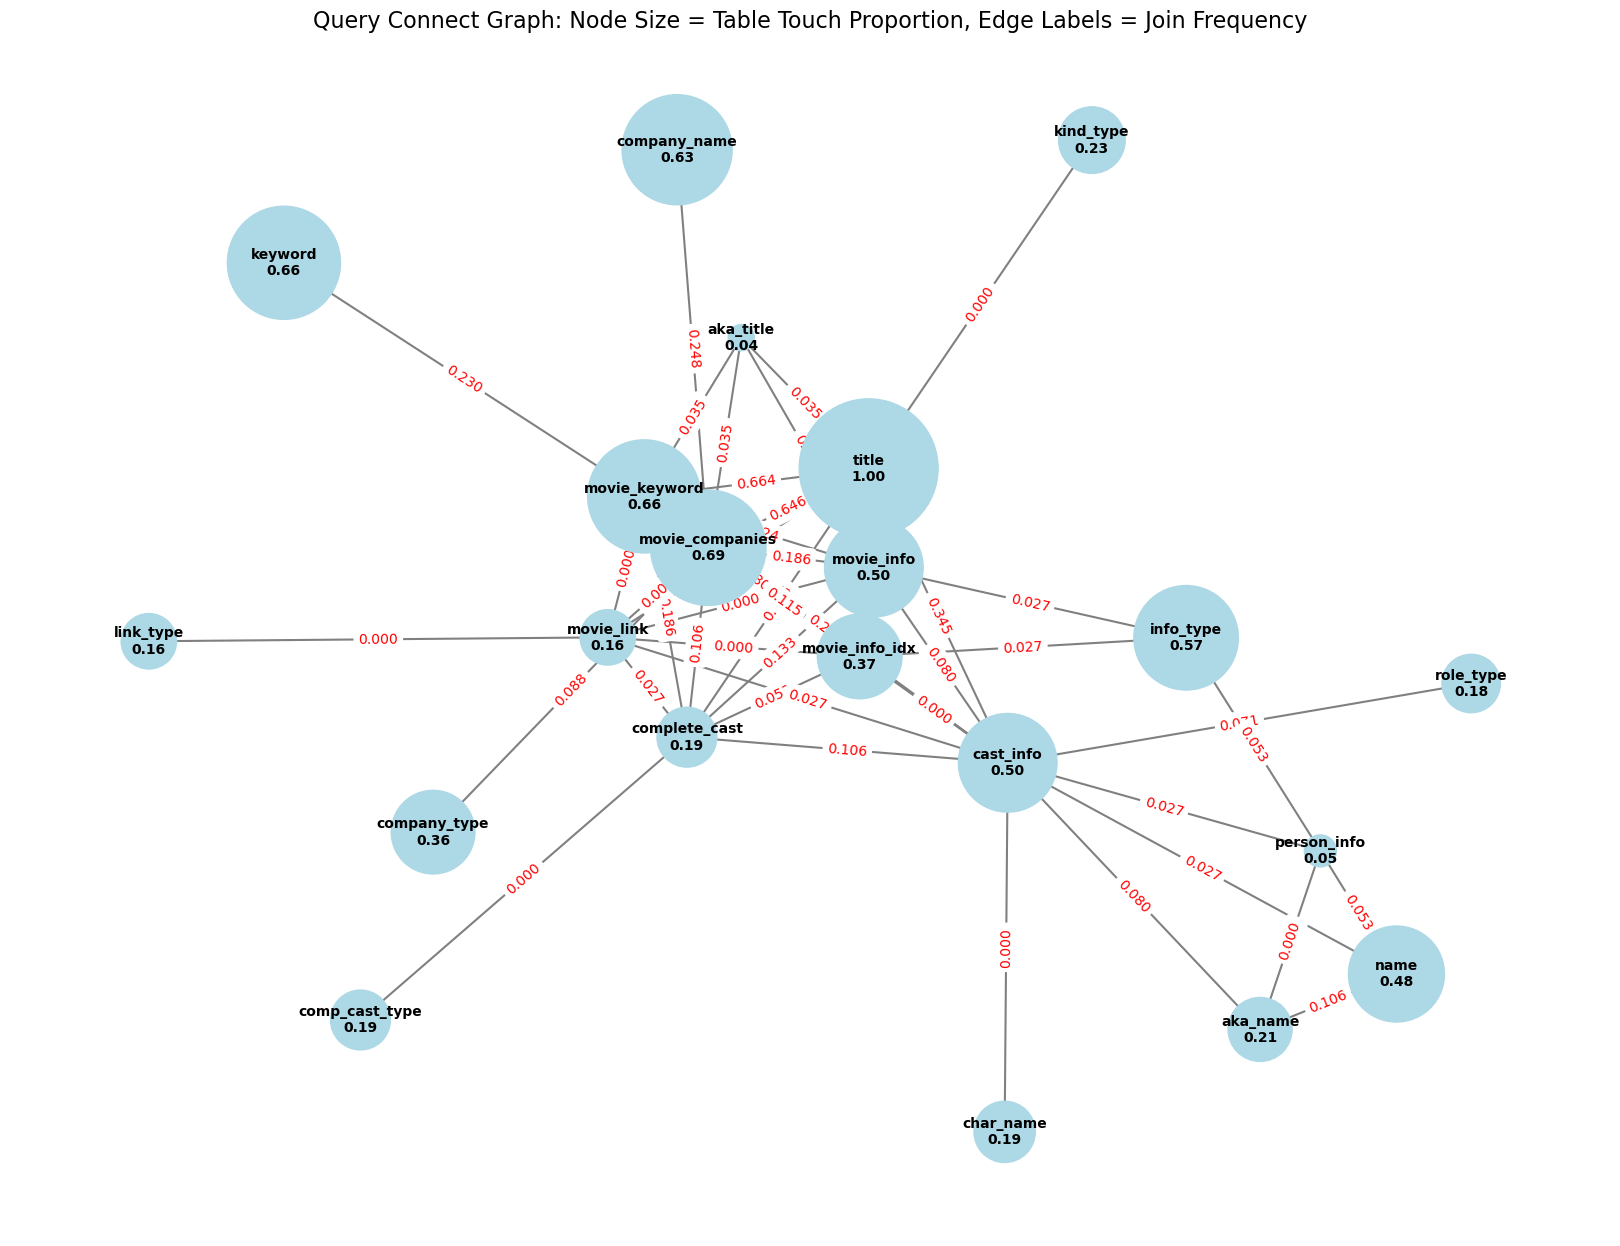

In [5]:
def visualize_query_connect_graph(
    query_connect_graph: nx.Graph,
    table_touch: Dict[str, int],
    total_queries: int,
    connection_proportions: Dict[Tuple[str, str], float]
):

    table_proportions = {table: count / total_queries for table, count in table_touch.items()}
    print("Table Proportions:", table_proportions)
    node_sizes = [table_proportions.get(table, 0) * 10000 for table in query_connect_graph.nodes()]
    print("Node Sizes:", node_sizes)
    node_labels = {table: f"{table}\n{proportion:.2f}" for table, proportion in table_proportions.items()}
    node_labels = {table: label for table, label in node_labels.items() if table in query_connect_graph.nodes()}
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(query_connect_graph, k=0.5, iterations=100, scale=2)
    
    nx.draw(
        query_connect_graph,
        pos,
        with_labels=True,
        labels=node_labels,
        node_size=node_sizes,
        node_color='lightblue',
        font_size=10,
        font_weight='bold',
        edge_color='gray',
        width=1.5
    )
    
    edge_labels = {(u, v): f"{connection_proportions.get((u, v), 0):.3f}" for u, v in query_connect_graph.edges()}
    nx.draw_networkx_edge_labels(query_connect_graph, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title("Query Connect Graph: Node Size = Table Touch Proportion, Edge Labels = Join Frequency", fontsize=16)
    plt.show()
    
visualize_query_connect_graph(query_connect_graph, table_touch, len(queries), connection_proportions)

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/data/hdd1

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/data/hdd1

Table Proportions: {'movie_info': 0.625, 'movie_companies': 0.375, 'movie_info_idx': 0.375, 'title': 1.0, 'company_type': 0.08333333333333333, 'info_type': 0.5416666666666666, 'kind_type': 0.125, 'company_name': 0.125, 'movie_keyword': 0.3333333333333333, 'keyword': 0.20833333333333334, 'person_info': 0.3333333333333333, 'name': 0.3333333333333333, 'cast_info': 0.5833333333333334, 'char_name': 0.16666666666666666, 'role_type': 0.08333333333333333, 'aka_title': 0.041666666666666664}
Node Sizes: [10000.0, 6250.0, 3750.0, 3750.0, 1250.0, 1250.0, 833.3333333333333, 5416.666666666666, 3333.333333333333, 2083.3333333333335, 5833.333333333334, 3333.333333333333, 3333.333333333333, 1666.6666666666665, 416.66666666666663]


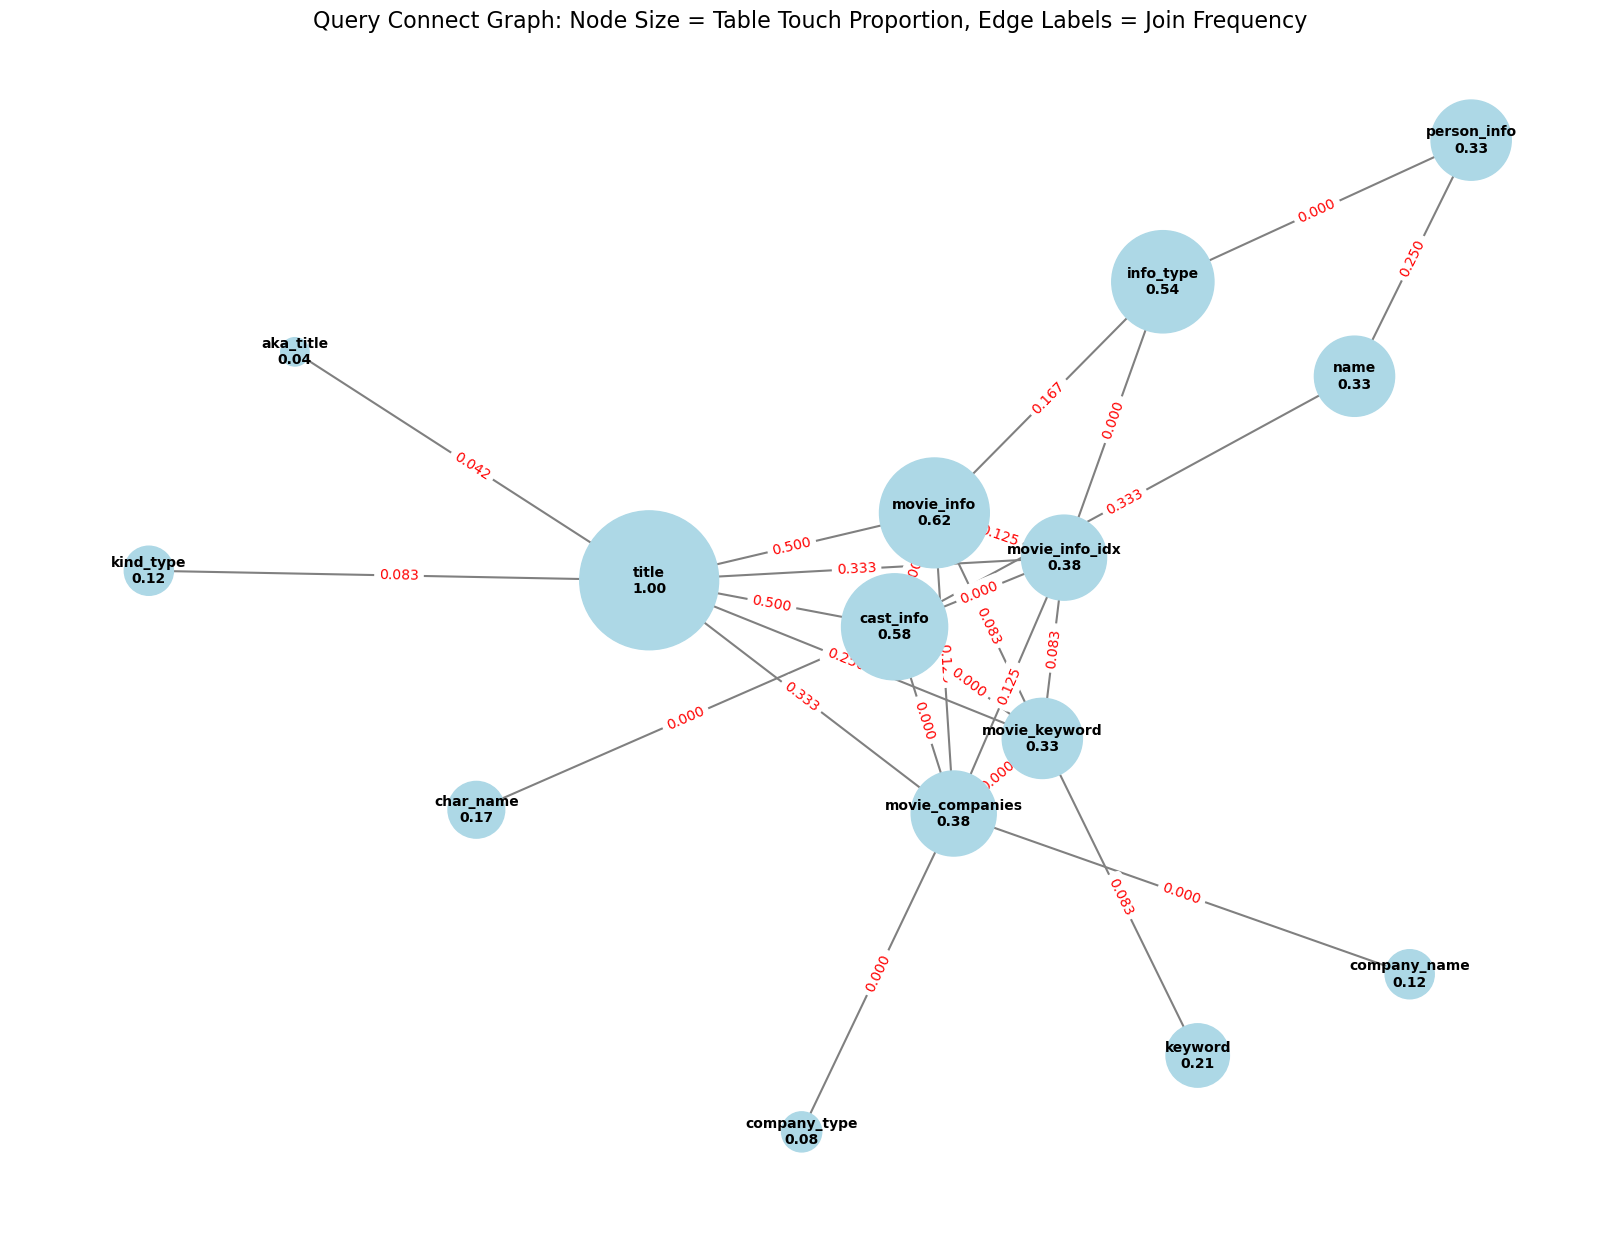

In [ ]:
query_directory = f"{REPO_ROOT}/workloads/imdb_pg_dataset/job_extended"

[queries,queryNames] = read_queries_from_directory(query_directory)
table_touch, column_touch, query_connect_graph, per_query_graphs, connection_proportions = analyze_workload(queries, queryNames)

# Convert column touch to DataFrame
df_column_touch = pd.DataFrame(list(column_touch.items()), columns=['Column', 'Touch Count'])

# Sort by touch count in descending order
df_column_touch = df_column_touch.sort_values(by='Touch Count', ascending=False)

# Calculate proportion compared to total number of queries
total_queries = len(queries)
df_column_touch['Proportion'] = df_column_touch['Touch Count'] / total_queries

# Convert table touch to DataFrame
df_table_touch = pd.DataFrame(list(table_touch.items()), columns=['Table', 'Touch Count'])

# Sort by touch count in descending order
df_table_touch = df_table_touch.sort_values(by='Touch Count', ascending=False)

# Calculate proportion compared to total number of queries
total_queries = len(queries)
df_table_touch['Proportion'] = df_table_touch['Touch Count'] / total_queries


visualize_query_connect_graph(query_connect_graph, table_touch, len(queries), connection_proportions)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

query_directory1 = f"{REPO_ROOT}/workloads/imdb_pg_dataset/job"
query_directory2 = f"{REPO_ROOT}/workloads/imdb_pg_dataset/job_extended"
# Read queries from both directories
queries1, queryNames1 = read_queries_from_directory(query_directory1)
queries2, queryNames2 = read_queries_from_directory(query_directory2)

# First workload
table_touch_1, _, _, _, join_props_1 = analyze_workload(queries1, queryNames1)

# Second workload
table_touch_2, _, _, _, join_props_2 = analyze_workload(queries2, queryNames2)

# def compute_distance(dict1, dict2):
#     all_keys = list(set(dict1.keys()) | set(dict2.keys()))
#     vec1 = np.array([dict1.get(k, 0) for k in all_keys]).reshape(1, -1)
#     vec2 = np.array([dict2.get(k, 0) for k in all_keys]).reshape(1, -1)
    
#     similarity = cosine_similarity(vec1, vec2)[0][0]
#     distance = 1 - similarity  # Convert to distance
#     return distance

# # Compute distances
# table_distance = compute_distance(table_touch_1, table_touch_2)
# join_distance = compute_distance(join_props_1, join_props_2)

# print(f"Table Touch Cosine Distance: {table_distance:.3f}")
# print(f"Join Pattern Cosine Distance: {join_distance:.3f}")

# overall_distance = 0.5 * table_distance + 0.5 * join_distance
# print(f"Overall Workload Distance: {overall_distance:.3f}")

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/data/hdd1

In [8]:
print("Table Touch 1:", table_touch_1)
print("Table Touch 2:", table_touch_2)
print("Join Pattern 1:", join_props_1)
print("Join Pattern 2:", join_props_2)

Table Touch 1: defaultdict(<class 'int'>, {'movie_companies': 78, 'title': 113, 'cast_info': 57, 'movie_keyword': 75, 'movie_info': 57, 'info_type': 64, 'name': 54, 'movie_info_idx': 42, 'keyword': 75, 'company_name': 71, 'person_info': 6, 'movie_link': 18, 'link_type': 18, 'aka_name': 24, 'company_type': 41, 'char_name': 22, 'role_type': 20, 'aka_title': 4, 'complete_cast': 21, 'comp_cast_type': 21, 'kind_type': 26})
Table Touch 2: defaultdict(<class 'int'>, {'movie_info': 15, 'movie_companies': 9, 'movie_info_idx': 9, 'title': 24, 'company_type': 2, 'info_type': 13, 'kind_type': 3, 'company_name': 3, 'movie_keyword': 8, 'keyword': 5, 'person_info': 8, 'name': 8, 'cast_info': 14, 'char_name': 4, 'role_type': 2, 'aka_title': 1})
Join Pattern 1: {('title', 'movie_info'): 0.415929203539823, ('title', 'movie_info_idx'): 0.36283185840707965, ('title', 'cast_info'): 0.34513274336283184, ('title', 'movie_keyword'): 0.6637168141592921, ('title', 'movie_companies'): 0.6460176991150443, ('cast_

In [9]:
# def visualize_per_query_graph(per_query_graphs: List[Tuple[str, nx.Graph]]):
#     num_graphs = min(12, len(per_query_graphs))
#     num_rows = (num_graphs + 2) // 3

#     fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))
#     axes = axes.flatten()

#     for i, (query_name, query_graph) in enumerate(per_query_graphs[:10]):
#         pos = nx.spring_layout(query_graph)
#         nx.draw(query_graph, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', ax=axes[i])
#         axes[i].set_title(f"{query_name} Query Graph")

#     for j in range(i + 1, len(axes)):
#         axes[j].axis('off')

#     plt.tight_layout()
#     plt.show()

# visualize_per_query_graph(per_query_graphs)

### Potential Idea: Cluster based on table usage similarity

In [10]:
# from sklearn.cluster import AgglomerativeClustering
# import numpy as np

# def query_clustering(queries: List[str], per_query_graphs: List[Tuple[str, nx.Graph]], n_clusters: int = 3) -> Dict[int, List[str]]:
#     """
#     Cluster queries based on table usage similarity.
#     Uses Agglomerative Clustering with Jaccard similarity.
#     """
#     table_sets = []
#     query_names = []
#     all_tables = set()
    
#     # Extract unique tables used in each query
#     for query_name, graph in per_query_graphs:
#         tables = set(graph.nodes)
#         table_sets.append(tables)
#         query_names.append(query_name)
#         all_tables.update(tables)
    
#     all_tables = list(all_tables)
#     table_index = {table: idx for idx, table in enumerate(all_tables)}
    
#     # Create binary feature vectors for table usage
#     feature_matrix = np.zeros((len(queries), len(all_tables)))
#     for i, tables in enumerate(table_sets):
#         for table in tables:
#             feature_matrix[i, table_index[table]] = 1
    
#     # Perform clustering
#     clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average')
#     cluster_labels = clustering.fit_predict(feature_matrix)
    
#     # Group queries by cluster
#     clustered_queries = defaultdict(list)
#     for query_name, cluster in zip(query_names, cluster_labels):
#         clustered_queries[cluster].append(query_name)
    
#     return dict(clustered_queries)

In [11]:
from processor import QueryProcessor, compute_workload_distance
qp1 = QueryProcessor(query_directory1, "imdb")
qp2 = QueryProcessor(query_directory2, "imdb_extended")

qp1.load()
qp2.load()
distance = compute_workload_distance(qp1, qp2)
print("JS Divergence between workloads:", distance)

WARN  loading config:  no such file: ./imdb-query-config.json
WARN  loading config:  no such file: ./imdb_extended-query-config.json
MetadataDistribution: tables with 113 items
MetadataDistribution: predicates with 113 items
MetadataDistribution: joins with 113 items
MetadataDistribution: tables with 24 items
MetadataDistribution: predicates with 24 items
MetadataDistribution: joins with 24 items
Computing workload distance...
Dist of Metadata joins, num_combos=113:
[[ci, movie_id, mc, movie_id], [ci, movie_id, mk, movie_id], [ci, movie_id, t, id], [mc, company_id, cn, id], [mc, movie_id, mk, movie_id], [mk, keyword_id, k, id], [n, id, ci, person_id], [t, id, mc, movie_id], [t, id, mk, movie_id]]                                                                                                                                                                                                                                                                                                       

In [12]:
def process_queries_in_directory(directory: str, conn):
    results = []
    sql_files = [f for f in os.listdir(directory) if f.endswith(".sql")]
    # sql_files = ['31c.sql']
    for filename in tqdm(sql_files, desc="Processing SQL files", unit="file"):
        print(f"Processing {filename}")
        filepath = os.path.join(directory, filename)
        
        try:
            with open(filepath, "r") as file:
                query = file.read().strip()
                if query:
                    parsed_query = parse_sql(query, split_parentheses=True)
                    aliases = parsed_query.get('aliases', {})
                    query_info = get_query_template(parsed_query, conn, alias_mapping=aliases)
                    print(f"Query Info for {filename}: {query_info}")
                    results.append((filename, query_info))
        except IOError as e:
            print(f"Error reading file {filename}: {e}")
    
    return results

In [13]:
from query_template import get_query_template_no_correl
from config import connect_to_db
from selectivity import DatabaseCache
import os
import re
from query_template import SQLInfoExtractor
import pglast

def build_query_profile(parsed_query: dict, query_name: str, query_info: dict, query: str, alias_mapping: Dict[str, str] = None) -> dict:
    sql_operator_pattern = re.compile(
        r'(>=|<=|!=|=|>|<|LIKE|like|IN|BETWEEN|IS\s+NOT\s+NULL|IS\s+NULL|NOT\s*(=|LIKE|like|IN|BETWEEN))'
    )

    node = pglast.parse_sql(query)
    extractor = SQLInfoExtractor()
    extractor(node)
    
    info = extractor.info

    selected_columns = []
    for column in parsed_query.get('select_columns', []):
        if '.' in column:
            table, column_name = column.split('.', 1)
            if alias_mapping and table in alias_mapping:
                table = alias_mapping[table]
            selected_columns.append((table, column_name))

    # Process join enumeration
    join_enumeration = []
    for i, join in enumerate(query_info.get('join_details', []), 1):
        join_entry = {
            'join_number': f'join{i}',
            'tables': join['tables'],
            'condition': join['condition'],
            'actual_rows': None
        }
        if 'execution_data' in join:
            join_entry['actual_rows'] = join['execution_data'].get('actual_rows')
        join_enumeration.append(join_entry)

    profile = {
        'query_name': query_name,
        'num_joins': len(parsed_query.get('joins', [])),
        'num_tables': len(set(parsed_query.get('from_tables', []))),
        'selected_columns': sorted(selected_columns),
        'num_columns_selected': len(parsed_query.get('select_columns', [])),
        'num_predicates': len(parsed_query.get('filters', [])),
        'low_selectivity_predicates': 0,
        'high_selectivity_predicates': 0,
        'tables': sorted(info.get('tables', [])),
        'predicates': sorted(info.get('predicates', [])),
        'joins': parsed_query.get('joins', []),
        'join_details': query_info.get('join_details', []),
        'join_enumeration': join_enumeration
    }

    for table, filters in query_info.get('filters', {}).items():
        for column, value in filters.items():
            if isinstance(value, float):  # valid selectivity
                selectivity = value
                if selectivity <= 0.05:
                    profile['low_selectivity_predicates'] += 1
                else:
                    profile['high_selectivity_predicates'] += 1
    
    return profile

def process_queries_in_directory_cached_db(directory: str, db_cache: DatabaseCache):
    results = []
    sql_files = [f for f in os.listdir(directory) if f.endswith(".sql")]
    query_profiles = []
    # sql_files = ['31c.sql']
    for filename in tqdm(sql_files, desc="Processing SQL files", unit="file"):
        filepath = os.path.join(directory, filename)
        try:
            with open(filepath, "r") as file:
                query = file.read().strip()
                if query:
                    parsed_query = parse_sql(query, split_parentheses=True)
                    aliases = parsed_query.get('aliases', {})
                    query_info = get_query_template_no_correl(parsed_query, db_cache, alias_mapping=aliases, original_query=query)
                    profile = build_query_profile(parsed_query, filename, query_info, query, alias_mapping=aliases)
                    query_profiles.append(profile)
                    results.append((filename, query_info))
        except IOError as e:
            print(f"Error reading file {filename}: {e}")
    
    return results, query_profiles

In [ ]:
query_directory = f"{REPO_ROOT}/workloads/imdb_pg_dataset/job"
conn = connect_to_db()
db_cache = DatabaseCache(conn)
db_cache.preload_all_tables()
conn.close()

Loaded 901,343 rows from aka_name
Loaded 361,472 rows from aka_title
Loaded 36,244,344 rows from cast_info
Loaded 3,140,339 rows from char_name
Loaded 4 rows from comp_cast_type
Loaded 234,997 rows from company_name
Loaded 4 rows from company_type
Loaded 135,086 rows from complete_cast
Loaded 113 rows from info_type
Loaded 134,170 rows from keyword
Loaded 7 rows from kind_type
Loaded 18 rows from link_type
Loaded 2,609,129 rows from movie_companies
Loaded 14,835,720 rows from movie_info
Loaded 1,380,035 rows from movie_info_idx
Loaded 4,523,930 rows from movie_keyword
Loaded 29,997 rows from movie_link
Loaded 4,167,491 rows from name
Loaded 2,963,664 rows from person_info
Loaded 12 rows from role_type
Loaded 2,528,312 rows from title


In [ ]:
query_directory = f"{REPO_ROOT}/workloads/imdb_pg_dataset/job"
results, query_profiles_job = process_queries_in_directory_cached_db(query_directory, db_cache)
# write_query_results_to_file(query_profiles_job, "job_query_templates.txt")

job_df_profiles = pd.DataFrame(query_profiles_job)

# Example statistics
print(job_df_profiles.describe())
job_df_profiles.head()

Processing SQL files:   0%|          | 0/113 [00:00<?, ?file/s]

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 2825, 'execution_time_ms': 650.534, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2825, 'time_ms': 621.438, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.01, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9996460176991151}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 2825, 'execution_time_ms': 621.438, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Gather', 'rows': 2840, 'time_ms': 111.114, 'node_type': 'Gather'}, {'relation': 'ci', 'rows': 1, 'time_ms': 0.179, 'node_type': 'Index Scan', 'index_condition': '(ci.movie_id = mk.movie_id)'}], 'selectivity': 0.9947183098591549, 'estimation_er

Processing SQL files:   1%|          | 1/113 [00:02<04:54,  2.63s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 68185, 'execution_time_ms': 3701.192, 'planner_estimate': 5, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Hash Join', 'rows': 109842, 'time_ms': 3378.093, 'node_type': 'Hash Join'}, {'relation': 't', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(t.id = ci.movie_id)'}], 'inferred_condition': True, 'selectivity': 0.6207552666557419, 'estimation_error': -0.9999266700887292}, {'node_type': 'Hash Join', 'join_condition': '(ml.link_type_id = lt.id)', 'output_rows': 109842, 'execution_time_ms': 3378.093, 'planner_estimate': 8, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 127027, 'time_ms': 3350.058, 'node_type': 'Nested Loop'}, {'relation': 'Hash', 'rows': 4, 'time_ms': 0.032, 'node_type': 'Hash'}], 'selectivity': 0.2161784502507341, 'estimation_error': -0.9999271681142

Processing SQL files:   2%|▏         | 2/113 [00:09<09:04,  4.90s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:   3%|▎         | 3/113 [00:09<05:18,  2.89s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Hash Join', 'join_condition': '(mc.company_type_id = ct.id)', 'output_rows': 0, 'execution_time_ms': 332.125, 'planner_estimate': 83, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 0, 'time_ms': 331.831, 'node_type': 'Nested Loop'}, {'relation': 'Hash', 'rows': 4, 'time_ms': 0.057, 'node_type': 'Hash'}], 'selectivity': 0, 'estimation_error': 0}, {'node_type': 'Nested Loop', 'join_condition': '(chn.id = ci.person_role_id)', 'output_rows': 0, 'execution_time_ms': 331.831, 'planner_estimate': 83, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Hash Join', 'rows': 0, 'time_ms': 331.827, 'node_type': 'Hash Join'}, {'relation': 'chn', 'rows': 0, 'time_ms': 0.0, 'node_type': 'Index Scan', 'index_condition': '(chn.id = ci.person_role_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': 0}, {'node_type': 'Hash Join', 'join_condition': '(ci.role_id = rt.id)

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:   4%|▎         | 4/113 [00:11<04:15,  2.34s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(t.id = at.movie_id)', 'output_rows': 11347, 'execution_time_ms': 1329.311, 'planner_estimate': 3924, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 25564, 'time_ms': 1269.072, 'node_type': 'Nested Loop'}, {'relation': 'at', 'rows': 0, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(at.movie_id = mk.movie_id)'}], 'selectivity': 0, 'estimation_error': -0.6541817220410682}, {'node_type': 'Nested Loop', 'join_condition': '(k.id = mk.keyword_id)', 'output_rows': 25564, 'execution_time_ms': 1269.072, 'planner_estimate': 1514, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 25564, 'time_ms': 1197.717, 'node_type': 'Nested Loop'}, {'relation': 'k', 'rows': 1, 'time_ms': 0.002, 'node_type': 'Index Only Scan', 'index_condition': '(k.id = mk.keyword_id)'}], 'inferred_condition': True, 'selectivity': 1.0,

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(cn.id = mc.company_id)', 'output_rows': 15, 'execution_time_ms': 191.515, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 66, 'time_ms': 191.024, 'node_type': 'Nested Loop'}, {'relation': 'cn', 'rows': 0, 'time_ms': 0.007, 'node_type': 'Index Scan', 'index_condition': '(cn.id = mc.company_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.9333333333333333}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mc.movie_id)', 'output_rows': 66, 'execution_time_ms': 191.024, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 3, 'time_ms': 190.936, 'node_type': 'Nested Loop'}, {'relation': 'mc', 'rows': 22, 'time_ms': 0.025, 'node_type': 'Index Scan', 'index_condition': '(mc.movie_id = mk.movie_id)'}], 'selectivity': 1.0, 'estimation_error': -0.

Processing SQL files:   4%|▍         | 5/113 [00:16<06:17,  3.50s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 28, 'execution_time_ms': 537.449, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 28, 'time_ms': 537.098, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.011, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9642857142857143}, {'node_type': 'Nested Loop', 'join_condition': '(cct2.id = cc.status_id)', 'output_rows': 28, 'execution_time_ms': 537.098, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 108, 'time_ms': 536.761, 'node_type': 'Nested Loop'}, {'relation': 'cct2', 'rows': 0, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(cct2.id = cc.status_id)'}], 'inferred_condition': True, 'selectivity':

Processing SQL files:   5%|▌         | 6/113 [00:18<05:06,  2.87s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(an.person_id = n.id)', 'output_rows': 352129, 'execution_time_ms': 5267.442, 'planner_estimate': 1275, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 157409, 'time_ms': 4904.168, 'node_type': 'Nested Loop'}, {'relation': 'an', 'rows': 2, 'time_ms': 0.002, 'node_type': 'Index Only Scan', 'index_condition': '(an.person_id = n.id)'}], 'inferred_condition': True, 'selectivity': 1.118516095013627, 'estimation_error': -0.9963791678617779}, {'node_type': 'Nested Loop', 'join_condition': '(cn.id = mc.company_id)', 'output_rows': 157409, 'execution_time_ms': 4904.168, 'planner_estimate': 531, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 645811, 'time_ms': 3513.514, 'node_type': 'Nested Loop'}, {'relation': 'cn', 'rows': 0, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(cn.id = mc.company_id)'}], 'i

Processing SQL files:   6%|▌         | 7/113 [00:24<06:44,  3.82s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:   7%|▋         | 8/113 [00:24<04:55,  2.81s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mc.movie_id = t.id)', 'output_rows': 7834, 'execution_time_ms': 524.846, 'planner_estimate': 7, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 7834, 'time_ms': 492.073, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.004, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'selectivity': 1.0, 'estimation_error': -0.9991064590247638}, {'node_type': 'Nested Loop', 'join_condition': '(cn.id = mc.company_id)', 'output_rows': 7834, 'execution_time_ms': 492.073, 'planner_estimate': 7, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 148552, 'time_ms': 238.726, 'node_type': 'Nested Loop'}, {'relation': 'cn', 'rows': 0, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(cn.id = mc.company_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:   8%|▊         | 9/113 [00:24<03:26,  1.99s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mc.movie_id = t.id)', 'output_rows': 47, 'execution_time_ms': 92.043, 'planner_estimate': 35, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Hash Join', 'rows': 47, 'time_ms': 91.312, 'node_type': 'Hash Join'}, {'relation': 't', 'rows': 1, 'time_ms': 0.015, 'node_type': 'Index Scan', 'index_condition': '(t.id = mi_idx.movie_id)'}], 'selectivity': 1.0, 'estimation_error': -0.2553191489361702}, {'node_type': 'Hash Join', 'join_condition': '(mc.company_type_id = ct.id)', 'output_rows': 47, 'execution_time_ms': 91.312, 'planner_estimate': 35, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 49, 'time_ms': 90.967, 'node_type': 'Nested Loop'}, {'relation': 'Hash', 'rows': 1, 'time_ms': 0.069, 'node_type': 'Hash'}], 'selectivity': 0.9591836734693877, 'estimation_error': -0.2553191489361702}, {'node_type': 'Nested Loop', 'join_condition': '(mc

Processing SQL files:   9%|▉         | 10/113 [00:25<02:51,  1.67s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  10%|▉         | 11/113 [00:26<02:23,  1.41s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mc.movie_id = t.id)', 'output_rows': 5228, 'execution_time_ms': 719.33, 'planner_estimate': 2, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 5228, 'time_ms': 684.591, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.006, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'selectivity': 1.0, 'estimation_error': -0.9996174445294568}, {'node_type': 'Nested Loop', 'join_condition': '(cn.id = mc.company_id)', 'output_rows': 5228, 'execution_time_ms': 684.591, 'planner_estimate': 2, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 148552, 'time_ms': 300.592, 'node_type': 'Nested Loop'}, {'relation': 'cn', 'rows': 0, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(cn.id = mc.company_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(t.id = at.movie_id)', 'output_rows': 2271, 'execution_time_ms': 748.759, 'planner_estimate': 135, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 7964, 'time_ms': 732.72, 'node_type': 'Nested Loop'}, {'relation': 'at', 'rows': 0, 'time_ms': 0.002, 'node_type': 'Index Only Scan', 'index_condition': '(at.movie_id = mk.movie_id)'}], 'selectivity': 0, 'estimation_error': -0.940554821664465}, {'node_type': 'Nested Loop', 'join_condition': '(k.id = mk.keyword_id)', 'output_rows': 7964, 'execution_time_ms': 732.72, 'planner_estimate': 52, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 7964, 'time_ms': 707.641, 'node_type': 'Nested Loop'}, {'relation': 'k', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Only Scan', 'index_condition': '(k.id = mk.keyword_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimat

Processing SQL files:  11%|█         | 12/113 [00:28<02:24,  1.43s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  12%|█▏        | 13/113 [00:28<01:47,  1.08s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mi.info_type_id = it1.id)', 'output_rows': 16, 'execution_time_ms': 73.646, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 16, 'time_ms': 73.57, 'node_type': 'Nested Loop'}, {'relation': 'it1', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Seq Scan'}], 'selectivity': 1.0, 'estimation_error': -0.9375}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mi.movie_id)', 'output_rows': 16, 'execution_time_ms': 73.57, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 315, 'time_ms': 53.284, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 0, 'time_ms': 0.064, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mk.movie_id)'}], 'selectivity': 0, 'estimation_error': -0.9375}, {'node_type': 'Nested Loop', 'join_condition': '(mc.company_type_id = ct.id)', 'ou

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(k.id = mk.keyword_id)', 'output_rows': 126, 'execution_time_ms': 276.562, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 126, 'time_ms': 276.13, 'node_type': 'Nested Loop'}, {'relation': 'k', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Only Scan', 'index_condition': '(k.id = mk.keyword_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9920634920634921}, {'node_type': 'Nested Loop', 'join_condition': '(ct.id = mc.company_type_id)', 'output_rows': 126, 'execution_time_ms': 276.13, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 126, 'time_ms': 275.987, 'node_type': 'Nested Loop'}, {'relation': 'ct', 'rows': 1, 'time_ms': 0.001, 'node_type': 'Index Only Scan', 'index_condition': '(ct.id = mc.company_type_id)'}], 'inferred_condition': T

Processing SQL files:  12%|█▏        | 14/113 [00:29<01:46,  1.08s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  13%|█▎        | 15/113 [00:33<03:15,  1.99s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(t.id = mi.movie_id)', 'output_rows': 410, 'execution_time_ms': 3829.604, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Gather', 'rows': 410, 'time_ms': 3823.803, 'node_type': 'Gather'}, {'relation': 't', 'rows': 1, 'time_ms': 0.013, 'node_type': 'Index Scan', 'index_condition': '(t.id = mi.movie_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9975609756097561}, {'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 137, 'execution_time_ms': 3579.805, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 35780, 'time_ms': 3341.078, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 0, 'time_ms': 0.006, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimat

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(chn.id = ci.person_role_id)', 'output_rows': 184, 'execution_time_ms': 2362.449, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 189, 'time_ms': 2361.316, 'node_type': 'Nested Loop'}, {'relation': 'chn', 'rows': 1, 'time_ms': 0.006, 'node_type': 'Index Only Scan', 'index_condition': '(chn.id = ci.person_role_id)'}], 'inferred_condition': True, 'selectivity': 0.9735449735449735, 'estimation_error': -0.9945652173913043}, {'node_type': 'Nested Loop', 'join_condition': '(n.id = an.person_id)', 'output_rows': 189, 'execution_time_ms': 2361.316, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Gather', 'rows': 170, 'time_ms': 2360.436, 'node_type': 'Gather'}, {'relation': 'an', 'rows': 1, 'time_ms': 0.005, 'node_type': 'Index Only Scan', 'index_condition': '(an.person_id = ci.person_id)'}], 'sel

Processing SQL files:  14%|█▍        | 16/113 [00:36<03:50,  2.38s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 258289, 'execution_time_ms': 9153.353, 'planner_estimate': 87, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2832555, 'time_ms': 3128.637, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 0, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.9996631680017345}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 2832555, 'execution_time_ms': 3128.637, 'planner_estimate': 1077, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 68316, 'time_ms': 751.094, 'node_type': 'Nested Loop'}, {'relation': 'ci', 'rows': 41, 'time_ms': 0.03, 'node_type': 'Index Scan', 'index_condition': '(ci.movie_id = mk.movie_id)'}], 'selectivity': 1.0112815

Processing SQL files:  15%|█▌        | 17/113 [00:47<07:45,  4.85s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(ml.movie_id = t.id)', 'output_rows': 14, 'execution_time_ms': 68.345, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 102, 'time_ms': 67.394, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 0, 'time_ms': 0.007, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'selectivity': 0, 'estimation_error': -0.9285714285714286}, {'node_type': 'Nested Loop', 'join_condition': '(mc.company_type_id = ct.id)', 'output_rows': 102, 'execution_time_ms': 67.394, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 103, 'time_ms': 66.88, 'node_type': 'Nested Loop'}, {'relation': 'ct', 'rows': 1, 'time_ms': 0.002, 'node_type': 'Seq Scan'}], 'selectivity': 0.9902912621359223, 'estimation_error': -0.9901960784313726}, {'node_type': 'Nested Loop', 'join_condition': 

Processing SQL files:  16%|█▌        | 18/113 [00:48<05:40,  3.58s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mi.info_type_id = it1.id)', 'output_rows': 31, 'execution_time_ms': 373.888, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 34, 'time_ms': 373.617, 'node_type': 'Nested Loop'}, {'relation': 'it1', 'rows': 1, 'time_ms': 0.005, 'node_type': 'Seq Scan'}], 'selectivity': 0.9117647058823529, 'estimation_error': -0.967741935483871}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mi.movie_id)', 'output_rows': 34, 'execution_time_ms': 373.617, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 50, 'time_ms': 367.231, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 1, 'time_ms': 0.126, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mk.movie_id)'}], 'selectivity': 0.68, 'estimation_error': -0.9705882352941176}, {'node_type': 'Nested Loop', 'join_c

Processing SQL files:  17%|█▋        | 19/113 [00:50<04:49,  3.08s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  18%|█▊        | 20/113 [00:50<03:25,  2.21s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Hash Join', 'join_condition': '(mc.company_type_id = ct.id)', 'output_rows': 1, 'execution_time_ms': 111.463, 'planner_estimate': 1835, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 26, 'time_ms': 111.126, 'node_type': 'Nested Loop'}, {'relation': 'Hash', 'rows': 1, 'time_ms': 0.069, 'node_type': 'Hash'}], 'selectivity': 0.038461538461538464, 'estimation_error': 1834.0}, {'node_type': 'Nested Loop', 'join_condition': '(mc.movie_id = t.id)', 'output_rows': 26, 'execution_time_ms': 111.126, 'planner_estimate': 7342, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2, 'time_ms': 110.943, 'node_type': 'Nested Loop'}, {'relation': 'mc', 'rows': 13, 'time_ms': 0.088, 'node_type': 'Index Scan', 'index_condition': '(mc.movie_id = t.id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': 281.38461538461536}, {'node_type': 'Nested Loop'

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(rt.id = ci.role_id)', 'output_rows': 15, 'execution_time_ms': 140.342, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 15, 'time_ms': 140.295, 'node_type': 'Nested Loop'}, {'relation': 'rt', 'rows': 1, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(rt.id = ci.role_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9333333333333333}, {'node_type': 'Nested Loop', 'join_condition': '(ci.person_id = n.id)', 'output_rows': 15, 'execution_time_ms': 140.295, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 275, 'time_ms': 138.676, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 0, 'time_ms': 0.006, 'node_type': 'Index Scan', 'index_condition': '(n.id = an.person_id)'}], 'selectivity': 0, 'estimation_error': -0.93333333333

Processing SQL files:  19%|█▊        | 21/113 [00:51<02:53,  1.89s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  19%|█▉        | 22/113 [00:51<02:05,  1.38s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mc.movie_id = t.id)', 'output_rows': 1, 'execution_time_ms': 112.994, 'planner_estimate': 4, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Hash Join', 'rows': 8, 'time_ms': 112.844, 'node_type': 'Hash Join'}, {'relation': 't', 'rows': 0, 'time_ms': 0.019, 'node_type': 'Index Scan', 'index_condition': '(t.id = mi_idx.movie_id)'}], 'selectivity': 0, 'estimation_error': 3.0}, {'node_type': 'Hash Join', 'join_condition': '(mc.company_type_id = ct.id)', 'output_rows': 8, 'execution_time_ms': 112.844, 'planner_estimate': 24, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 8, 'time_ms': 112.485, 'node_type': 'Nested Loop'}, {'relation': 'Hash', 'rows': 1, 'time_ms': 0.07, 'node_type': 'Hash'}], 'selectivity': 1.0, 'estimation_error': 2.0}, {'node_type': 'Nested Loop', 'join_condition': '(mc.movie_id = mi_idx.movie_id)', 'output_rows': 8, 'e

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  20%|██        | 23/113 [00:51<01:37,  1.09s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(cn.id = mc.company_id)', 'output_rows': 14899, 'execution_time_ms': 208.338, 'planner_estimate': 49, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 14916, 'time_ms': 177.271, 'node_type': 'Nested Loop'}, {'relation': 'cn', 'rows': 1, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(cn.id = mc.company_id)'}], 'inferred_condition': True, 'selectivity': 0.9988602842585144, 'estimation_error': -0.9967111886703806}, {'node_type': 'Nested Loop', 'join_condition': '(mc.company_type_id = ct.id)', 'output_rows': 14916, 'execution_time_ms': 177.271, 'planner_estimate': 55, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 15510, 'time_ms': 172.382, 'node_type': 'Nested Loop'}, {'relation': 'Materialize', 'rows': 1, 'time_ms': 0.0, 'node_type': 'Materialize'}], 'selectivity': 0.9617021276595744, 'estimation

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 11, 'execution_time_ms': 261.74, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 268, 'time_ms': 255.89, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 0, 'time_ms': 0.021, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.9090909090909091}, {'node_type': 'Nested Loop', 'join_condition': '(ci.movie_id = t.id)', 'output_rows': 268, 'execution_time_ms': 255.89, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Gather', 'rows': 358, 'time_ms': 176.648, 'node_type': 'Gather'}, {'relation': 'ci', 'rows': 1, 'time_ms': 0.22, 'node_type': 'Index Scan', 'index_condition': '(ci.movie_id = t.id)'}], 'inferred_condition': True, 'selectivity': 0.7486033519553073, 'es

Processing SQL files:  21%|██        | 24/113 [00:53<01:59,  1.35s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(it.id = pi.info_type_id)', 'output_rows': 32, 'execution_time_ms': 1167.36, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 32, 'time_ms': 1167.228, 'node_type': 'Nested Loop'}, {'relation': 'it', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(it.id = pi.info_type_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.96875}, {'node_type': 'Nested Loop', 'join_condition': '(n.id = an.person_id)', 'output_rows': 32, 'execution_time_ms': 1167.228, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 14, 'time_ms': 1166.954, 'node_type': 'Nested Loop'}, {'relation': 'an', 'rows': 2, 'time_ms': 0.017, 'node_type': 'Index Scan', 'index_condition': '(an.person_id = ci.person_id)'}], 'selectivity': 1.1428571428571428, 'estima

Processing SQL files:  22%|██▏       | 25/113 [00:57<02:56,  2.00s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 5406, 'execution_time_ms': 1476.757, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 5406, 'time_ms': 1412.506, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.011, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9998150203477617}, {'node_type': 'Nested Loop', 'join_condition': '(chn.id = ci.person_role_id)', 'output_rows': 5406, 'execution_time_ms': 1412.506, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 189844, 'time_ms': 916.696, 'node_type': 'Nested Loop'}, {'relation': 'chn', 'rows': 0, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(chn.id = ci.person_role_id)'}], 'inferred_condition': T

Processing SQL files:  23%|██▎       | 26/113 [00:59<02:52,  1.99s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(it1.id = mi.info_type_id)', 'output_rows': 1273, 'execution_time_ms': 354.178, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Gather', 'rows': 1333, 'time_ms': 351.737, 'node_type': 'Gather'}, {'relation': 'it1', 'rows': 1, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(it1.id = mi.info_type_id)'}], 'inferred_condition': True, 'selectivity': 0.9549887471867967, 'estimation_error': -0.9992144540455616}, {'node_type': 'Nested Loop', 'join_condition': '(k.id = mk.keyword_id)', 'output_rows': 666, 'execution_time_ms': 287.346, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 24662, 'time_ms': 215.726, 'node_type': 'Nested Loop'}, {'relation': 'k', 'rows': 0, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(k.id = mk.keyword_id)'}], 'inferred_condition': Tru

Processing SQL files:  24%|██▍       | 27/113 [01:00<02:34,  1.80s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  25%|██▍       | 28/113 [01:10<05:58,  4.22s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 2832555, 'execution_time_ms': 9474.127, 'planner_estimate': 1077, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2832555, 'time_ms': 3260.825, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9996197779036947}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 2832555, 'execution_time_ms': 3260.825, 'planner_estimate': 1077, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 68316, 'time_ms': 818.68, 'node_type': 'Nested Loop'}, {'relation': 'ci', 'rows': 41, 'time_ms': 0.031, 'node_type': 'Index Scan', 'index_condition': '(ci.movie_id = mk.movie_id)'}], 'selectivity': 1.01

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(k.id = mk.keyword_id)', 'output_rows': 477, 'execution_time_ms': 22.681, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 6483, 'time_ms': 15.04, 'node_type': 'Nested Loop'}, {'relation': 'k', 'rows': 0, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(k.id = mk.keyword_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.9979035639412998}, {'node_type': 'Nested Loop', 'join_condition': '(ml.movie_id = mk.movie_id)', 'output_rows': 6483, 'execution_time_ms': 15.04, 'planner_estimate': 34, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 705, 'time_ms': 12.657, 'node_type': 'Nested Loop'}, {'relation': 'mk', 'rows': 9, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(mk.movie_id = mc.movie_id)'}], 'selectivity': 1.0217494089834516, 'es

Processing SQL files:  26%|██▌       | 29/113 [01:11<04:41,  3.35s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  27%|██▋       | 30/113 [01:13<03:55,  2.84s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Hash Join', 'join_condition': '(mi.info_type_id = it2.id)', 'output_rows': 37034, 'execution_time_ms': 1427.912, 'planner_estimate': 11, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 172109, 'time_ms': 1406.931, 'node_type': 'Nested Loop'}, {'relation': 'Hash', 'rows': 1, 'time_ms': 0.074, 'node_type': 'Hash'}], 'selectivity': 0.21517759094527306, 'estimation_error': -0.9997029756440028}, {'node_type': 'Nested Loop', 'join_condition': '(mi.movie_id = t.id)', 'output_rows': 172109, 'execution_time_ms': 1406.931, 'planner_estimate': 1239, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 5490, 'time_ms': 1232.133, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 31, 'time_ms': 0.027, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = t.id)'}], 'inferred_condition': True, 'selectivity': 1.0112756331159292, 'estimation_error': -0.992

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  27%|██▋       | 31/113 [01:15<03:33,  2.61s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = an.person_id)', 'output_rows': 249455, 'execution_time_ms': 1861.837, 'planner_estimate': 708, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 169273, 'time_ms': 1265.853, 'node_type': 'Nested Loop'}, {'relation': 'an', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(an.person_id = ci.person_id)'}], 'selectivity': 1.47368452145351, 'estimation_error': -0.9971618127517989}, {'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 169273, 'execution_time_ms': 1265.853, 'planner_estimate': 295, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 169273, 'time_ms': 641.187, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Only Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 's

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  28%|██▊       | 32/113 [01:21<04:51,  3.59s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 5400, 'execution_time_ms': 5511.665, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 5400, 'time_ms': 5451.023, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.011, 'node_type': 'Index Only Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9998148148148148}, {'node_type': 'Nested Loop', 'join_condition': '(k.id = mk.keyword_id)', 'output_rows': 5400, 'execution_time_ms': 5451.023, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1145482, 'time_ms': 2869.733, 'node_type': 'Nested Loop'}, {'relation': 'k', 'rows': 0, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(k.id = mk.keyword_id)'}], 'inferred_condition': True, 's

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  29%|██▉       | 33/113 [01:21<03:26,  2.58s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(k.id = mk.keyword_id)', 'output_rows': 18, 'execution_time_ms': 32.879, 'planner_estimate': 5, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 18, 'time_ms': 32.695, 'node_type': 'Nested Loop'}, {'relation': 'k', 'rows': 1, 'time_ms': 0.009, 'node_type': 'Index Only Scan', 'index_condition': '(k.id = mk.keyword_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.7222222222222222}, {'node_type': 'Nested Loop', 'join_condition': '(mk.movie_id = t.id)', 'output_rows': 18, 'execution_time_ms': 32.695, 'planner_estimate': 5, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2, 'time_ms': 32.64, 'node_type': 'Nested Loop'}, {'relation': 'mk', 'rows': 12, 'time_ms': 0.033, 'node_type': 'Index Scan', 'index_condition': '(mk.movie_id = t.id)'}], 'inferred_condition': True, 'selectivity': 0.75, 'e

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mc.company_type_id = ct.id)', 'output_rows': 46281, 'execution_time_ms': 1335.825, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 46281, 'time_ms': 1153.588, 'node_type': 'Nested Loop'}, {'relation': 'ct', 'rows': 1, 'time_ms': 0.001, 'node_type': 'Seq Scan'}], 'selectivity': 1.0, 'estimation_error': -0.9999783928610013}, {'node_type': 'Nested Loop', 'join_condition': '(cn.id = mc.company_id)', 'output_rows': 46281, 'execution_time_ms': 1153.588, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 64848, 'time_ms': 891.245, 'node_type': 'Nested Loop'}, {'relation': 'cn', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(cn.id = mc.company_id)'}], 'inferred_condition': True, 'selectivity': 0.7136843079200592, 'estimation_error': -0.999978392861

Processing SQL files:  30%|███       | 34/113 [01:24<03:37,  2.75s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  31%|███       | 35/113 [01:25<02:41,  2.08s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(k.id = mk.keyword_id)', 'output_rows': 82, 'execution_time_ms': 309.518, 'planner_estimate': 6, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 82, 'time_ms': 308.867, 'node_type': 'Nested Loop'}, {'relation': 'k', 'rows': 1, 'time_ms': 0.007, 'node_type': 'Index Only Scan', 'index_condition': '(k.id = mk.keyword_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.926829268292683}, {'node_type': 'Nested Loop', 'join_condition': '(mk.movie_id = t.id)', 'output_rows': 82, 'execution_time_ms': 308.867, 'planner_estimate': 6, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 14, 'time_ms': 308.568, 'node_type': 'Nested Loop'}, {'relation': 'mk', 'rows': 6, 'time_ms': 0.019, 'node_type': 'Index Scan', 'index_condition': '(mk.movie_id = t.id)'}], 'inferred_condition': True, 'selectivity': 0.97

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(t.id = mi.movie_id)', 'output_rows': 5, 'execution_time_ms': 164.874, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 405, 'time_ms': 128.059, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 0, 'time_ms': 0.09, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mk.movie_id)'}], 'selectivity': 0, 'estimation_error': -0.8}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mk.movie_id)', 'output_rows': 405, 'execution_time_ms': 128.059, 'planner_estimate': 67, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 12951, 'time_ms': 58.591, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 0, 'time_ms': 0.005, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.8345679012345679}, {'

Processing SQL files:  32%|███▏      | 36/113 [01:26<02:07,  1.65s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(it.id = mi.info_type_id)', 'output_rows': 0, 'execution_time_ms': 140.697, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 0, 'time_ms': 140.696, 'node_type': 'Nested Loop'}, {'relation': 'it', 'rows': 0, 'time_ms': 0.0, 'node_type': 'Index Only Scan', 'index_condition': '(it.id = mi.info_type_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': 0}, {'node_type': 'Nested Loop', 'join_condition': '(mi.movie_id = t.id)', 'output_rows': 0, 'execution_time_ms': 140.696, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Gather', 'rows': 0, 'time_ms': 140.694, 'node_type': 'Gather'}, {'relation': 'mi', 'rows': 0, 'time_ms': 0.0, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = t.id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': 0}, {'node_

Processing SQL files:  33%|███▎      | 37/113 [01:26<01:47,  1.42s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(it.id = pi.info_type_id)', 'output_rows': 16, 'execution_time_ms': 405.313, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 16, 'time_ms': 405.238, 'node_type': 'Nested Loop'}, {'relation': 'it', 'rows': 1, 'time_ms': 0.004, 'node_type': 'Index Scan', 'index_condition': '(it.id = pi.info_type_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9375}, {'node_type': 'Nested Loop', 'join_condition': '(n.id = an.person_id)', 'output_rows': 16, 'execution_time_ms': 405.238, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 8, 'time_ms': 405.102, 'node_type': 'Nested Loop'}, {'relation': 'an', 'rows': 2, 'time_ms': 0.015, 'node_type': 'Index Scan', 'index_condition': '(an.person_id = ci.person_id)'}], 'selectivity': 1.0, 'estimation_error': -0.9375

Processing SQL files:  34%|███▎      | 38/113 [01:29<02:15,  1.80s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mi.movie_id = t.id)', 'output_rows': 26153, 'execution_time_ms': 7374.95, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 26153, 'time_ms': 7274.361, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'selectivity': 1.0, 'estimation_error': -0.9999617634688182}, {'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 26153, 'execution_time_ms': 7274.361, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 42900, 'time_ms': 7036.837, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.005, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 0.6096270396270397, 'est

Processing SQL files:  35%|███▍      | 39/113 [01:38<04:45,  3.86s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(it1.id = mi.info_type_id)', 'output_rows': 132, 'execution_time_ms': 228.561, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 132, 'time_ms': 228.196, 'node_type': 'Nested Loop'}, {'relation': 'it1', 'rows': 1, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(it1.id = mi.info_type_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9924242424242424}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mi.movie_id)', 'output_rows': 132, 'execution_time_ms': 228.196, 'planner_estimate': 10, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1891, 'time_ms': 173.316, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 0, 'time_ms': 0.029, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mc.movie_id)'}], 'selectivity': 0, 'estimatio

Processing SQL files:  35%|███▌      | 40/113 [01:39<03:53,  3.20s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  36%|███▋      | 41/113 [01:40<02:53,  2.41s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(ct.id = mc.company_type_id)', 'output_rows': 26, 'execution_time_ms': 371.911, 'planner_estimate': 3, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 26, 'time_ms': 371.785, 'node_type': 'Nested Loop'}, {'relation': 'ct', 'rows': 1, 'time_ms': 0.004, 'node_type': 'Index Only Scan', 'index_condition': '(ct.id = mc.company_type_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.8846153846153846}, {'node_type': 'Nested Loop', 'join_condition': '(chn.id = ci.person_role_id)', 'output_rows': 26, 'execution_time_ms': 371.785, 'planner_estimate': 3, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Hash Join', 'rows': 28, 'time_ms': 371.06, 'node_type': 'Hash Join'}, {'relation': 'chn', 'rows': 1, 'time_ms': 0.025, 'node_type': 'Index Scan', 'index_condition': '(chn.id = ci.person_role_id)'}], 'inferred_condition':

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(t.id = mi.movie_id)', 'output_rows': 7250, 'execution_time_ms': 463.077, 'planner_estimate': 591, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 7874, 'time_ms': 136.671, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 1, 'time_ms': 0.041, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mk.movie_id)'}], 'selectivity': 0.920751841503683, 'estimation_error': -0.9184827586206896}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mk.movie_id)', 'output_rows': 7874, 'execution_time_ms': 136.671, 'planner_estimate': 305, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 12951, 'time_ms': 61.008, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.005, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'inferred_condition': True, 'selectivity': 0.60798

Processing SQL files:  37%|███▋      | 42/113 [01:42<02:33,  2.16s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(chn.id = ci.person_role_id)', 'output_rows': 16308, 'execution_time_ms': 250.018, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 16740, 'time_ms': 230.275, 'node_type': 'Nested Loop'}, {'relation': 'chn', 'rows': 1, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(chn.id = ci.person_role_id)'}], 'inferred_condition': True, 'selectivity': 0.9741935483870968, 'estimation_error': -0.9999386804022565}, {'node_type': 'Nested Loop', 'join_condition': '(n.id = an.person_id)', 'output_rows': 16740, 'execution_time_ms': 230.275, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 3966, 'time_ms': 220.586, 'node_type': 'Nested Loop'}, {'relation': 'an', 'rows': 4, 'time_ms': 0.002, 'node_type': 'Index Only Scan', 'index_condition': '(an.person_id = pi.person_id)'

Processing SQL files:  38%|███▊      | 43/113 [01:46<03:18,  2.84s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  39%|███▉      | 44/113 [01:48<02:52,  2.50s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = an.person_id)', 'output_rows': 319932, 'execution_time_ms': 1521.618, 'planner_estimate': 965, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 221609, 'time_ms': 1044.788, 'node_type': 'Nested Loop'}, {'relation': 'an', 'rows': 1, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(an.person_id = ci.person_id)'}], 'selectivity': 1.44367782896904, 'estimation_error': -0.9969837340434843}, {'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 221609, 'execution_time_ms': 1044.788, 'planner_estimate': 402, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 221609, 'time_ms': 517.444, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.002, 'node_type': 'Index Only Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 's

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(ml.movie_id = t.id)', 'output_rows': 38, 'execution_time_ms': 113.964, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 308, 'time_ms': 112.727, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 0, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'selectivity': 0, 'estimation_error': -0.9736842105263158}, {'node_type': 'Nested Loop', 'join_condition': '(ml.movie_id = mi.movie_id)', 'output_rows': 308, 'execution_time_ms': 112.727, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 402, 'time_ms': 106.172, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 1, 'time_ms': 0.015, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mk.movie_id)'}], 'selectivity': 0.7661691542288557, 'estimation_error': -0.9967532467

Processing SQL files:  40%|███▉      | 45/113 [01:49<02:26,  2.15s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Hash Join', 'join_condition': '(mi.info_type_id = it.id)', 'output_rows': 167, 'execution_time_ms': 157.672, 'planner_estimate': 14116, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 167, 'time_ms': 157.47, 'node_type': 'Nested Loop'}, {'relation': 'Hash', 'rows': 113, 'time_ms': 0.061, 'node_type': 'Hash'}], 'selectivity': 0.008849557522123894, 'estimation_error': 83.52694610778443}, {'node_type': 'Nested Loop', 'join_condition': '(mi.movie_id = t.id)', 'output_rows': 167, 'execution_time_ms': 157.47, 'planner_estimate': 14116, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 192, 'time_ms': 140.33, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 1, 'time_ms': 0.088, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = t.id)'}], 'inferred_condition': True, 'selectivity': 0.8697916666666666, 'estimation_error': 83.52694610778443},

Processing SQL files:  41%|████      | 46/113 [01:50<02:04,  1.86s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(k.id = mk.keyword_id)', 'output_rows': 2, 'execution_time_ms': 71.901, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 357, 'time_ms': 69.268, 'node_type': 'Nested Loop'}, {'relation': 'k', 'rows': 0, 'time_ms': 0.007, 'node_type': 'Index Scan', 'index_condition': '(k.id = mk.keyword_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.5}, {'node_type': 'Nested Loop', 'join_condition': '(mk.movie_id = t.id)', 'output_rows': 357, 'execution_time_ms': 69.268, 'planner_estimate': 47, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 24, 'time_ms': 67.746, 'node_type': 'Nested Loop'}, {'relation': 'mk', 'rows': 15, 'time_ms': 0.06, 'node_type': 'Index Scan', 'index_condition': '(mk.movie_id = t.id)'}], 'inferred_condition': True, 'selectivity': 0.9916666666666667, 'estima

Processing SQL files:  42%|████▏     | 47/113 [01:51<01:41,  1.54s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mi.info_type_id = it1.id)', 'output_rows': 21489, 'execution_time_ms': 2906.2, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 24612, 'time_ms': 2726.677, 'node_type': 'Nested Loop'}, {'relation': 'it1', 'rows': 1, 'time_ms': 0.005, 'node_type': 'Seq Scan'}], 'selectivity': 0.8731106777181863, 'estimation_error': -0.999953464563265}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mi.movie_id)', 'output_rows': 24612, 'execution_time_ms': 2726.677, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 23425, 'time_ms': 684.923, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 1, 'time_ms': 0.086, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mk.movie_id)'}], 'selectivity': 1.0506723585912487, 'estimation_error': -0.9999593694132943}, {'node_ty

Processing SQL files:  42%|████▏     | 48/113 [01:56<02:41,  2.49s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(kt2.id = t2.kind_id)', 'output_rows': 4, 'execution_time_ms': 53.496, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 4, 'time_ms': 53.473, 'node_type': 'Nested Loop'}, {'relation': 'kt2', 'rows': 1, 'time_ms': 0.005, 'node_type': 'Index Scan', 'index_condition': '(kt2.id = t2.kind_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.75}, {'node_type': 'Nested Loop', 'join_condition': '(ml.linked_movie_id = t2.id)', 'output_rows': 4, 'execution_time_ms': 53.473, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 10, 'time_ms': 53.335, 'node_type': 'Nested Loop'}, {'relation': 't2', 'rows': 0, 'time_ms': 0.013, 'node_type': 'Index Scan', 'index_condition': '(t2.id = mc2.movie_id)'}], 'selectivity': 0, 'estimation_error': -0.75}, {'node_type': 'N

Processing SQL files:  43%|████▎     | 49/113 [01:57<02:17,  2.15s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mi.movie_id = t.id)', 'output_rows': 4407, 'execution_time_ms': 3077.971, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 4407, 'time_ms': 3045.617, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.007, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'selectivity': 1.0, 'estimation_error': -0.9997730882686635}, {'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 4407, 'execution_time_ms': 3045.617, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 7112, 'time_ms': 2966.758, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.01, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 0.6196569178852643, 'estimat

Processing SQL files:  44%|████▍     | 50/113 [02:02<03:00,  2.87s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(t.kind_id = kt.id)', 'output_rows': 1, 'execution_time_ms': 176.752, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2, 'time_ms': 176.735, 'node_type': 'Nested Loop'}, {'relation': 'kt', 'rows': 1, 'time_ms': 0.006, 'node_type': 'Seq Scan'}], 'selectivity': 0.5, 'estimation_error': 0.0}, {'node_type': 'Nested Loop', 'join_condition': '(mi_idx.info_type_id = it2.id)', 'output_rows': 2, 'execution_time_ms': 176.735, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 3, 'time_ms': 176.694, 'node_type': 'Nested Loop'}, {'relation': 'it2', 'rows': 1, 'time_ms': 0.011, 'node_type': 'Seq Scan'}], 'selectivity': 0.6666666666666666, 'estimation_error': -0.5}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mi_idx.movie_id)', 'output_rows': 3, 'execution_time_ms': 176.69

Processing SQL files:  45%|████▌     | 51/113 [02:04<02:38,  2.56s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(ml.movie_id = t.id)', 'output_rows': 1874, 'execution_time_ms': 81.273, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1874, 'time_ms': 78.121, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'selectivity': 1.0, 'estimation_error': -0.9994663820704376}, {'node_type': 'Nested Loop', 'join_condition': '(ml.movie_id = mi.movie_id)', 'output_rows': 1874, 'execution_time_ms': 78.121, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 402, 'time_ms': 72.753, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 5, 'time_ms': 0.012, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mk.movie_id)'}], 'selectivity': 0.9323383084577115, 'estimation_error': -0.99946638

Processing SQL files:  46%|████▌     | 52/113 [02:05<02:15,  2.23s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(ci.movie_id = t.id)', 'output_rows': 2036, 'execution_time_ms': 424.231, 'planner_estimate': 703, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2036, 'time_ms': 415.433, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.004, 'node_type': 'Index Scan', 'index_condition': '(t.id = mc.movie_id)'}], 'selectivity': 1.0, 'estimation_error': -0.6547151277013753}, {'node_type': 'Nested Loop', 'join_condition': '(chn.id = ci.person_role_id)', 'output_rows': 2036, 'execution_time_ms': 415.433, 'planner_estimate': 703, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2128, 'time_ms': 407.621, 'node_type': 'Nested Loop'}, {'relation': 'chn', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(chn.id = ci.person_role_id)'}], 'inferred_condition': True, 'selectivity': 0.956766917

Processing SQL files:  47%|████▋     | 53/113 [02:06<01:47,  1.79s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(t.id = mi.movie_id)', 'output_rows': 206, 'execution_time_ms': 194.589, 'planner_estimate': 68, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2235, 'time_ms': 99.748, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 0, 'time_ms': 0.042, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mk.movie_id)'}], 'selectivity': 0, 'estimation_error': -0.6699029126213593}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mk.movie_id)', 'output_rows': 2235, 'execution_time_ms': 99.748, 'planner_estimate': 175, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 12951, 'time_ms': 45.456, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 0, 'time_ms': 0.004, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.9

Processing SQL files:  48%|████▊     | 54/113 [02:07<01:31,  1.55s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  49%|████▊     | 55/113 [02:07<01:10,  1.22s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(ml.movie_id = t.id)', 'output_rows': 6946, 'execution_time_ms': 286.735, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 6946, 'time_ms': 260.173, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'selectivity': 1.0, 'estimation_error': -0.9998560322487763}, {'node_type': 'Nested Loop', 'join_condition': '(ml.link_type_id = lt.id)', 'output_rows': 6946, 'execution_time_ms': 260.173, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 6946, 'time_ms': 223.815, 'node_type': 'Nested Loop'}, {'relation': 'lt', 'rows': 7, 'time_ms': 0.002, 'node_type': 'Seq Scan'}], 'selectivity': 0.14285714285714285, 'estimation_error': -0.9998560322487763}, {'node_type': 'Nested Loop', 'join_co

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(cn.id = mc.company_id)', 'output_rows': 8373, 'execution_time_ms': 1682.682, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 8771, 'time_ms': 1638.8, 'node_type': 'Nested Loop'}, {'relation': 'cn', 'rows': 1, 'time_ms': 0.004, 'node_type': 'Index Scan', 'index_condition': '(cn.id = mc.company_id)'}], 'inferred_condition': True, 'selectivity': 0.9546231900581461, 'estimation_error': -0.9998805684939687}, {'node_type': 'Nested Loop', 'join_condition': '(mi_idx.info_type_id = it2.id)', 'output_rows': 8771, 'execution_time_ms': 1638.8, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 25980, 'time_ms': 1318.306, 'node_type': 'Nested Loop'}, {'relation': 'it2', 'rows': 1, 'time_ms': 0.01, 'node_type': 'Seq Scan'}], 'selectivity': 0.3376058506543495, 'estimation_error': -0.9

Processing SQL files:  50%|████▉     | 56/113 [02:11<01:54,  2.02s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(cn.id = mc.company_id)', 'output_rows': 1620, 'execution_time_ms': 242.531, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 7128, 'time_ms': 232.044, 'node_type': 'Nested Loop'}, {'relation': 'cn', 'rows': 0, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(cn.id = mc.company_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.9993827160493827}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mc.movie_id)', 'output_rows': 7128, 'execution_time_ms': 232.044, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 324, 'time_ms': 229.623, 'node_type': 'Nested Loop'}, {'relation': 'mc', 'rows': 22, 'time_ms': 0.005, 'node_type': 'Index Scan', 'index_condition': '(mc.movie_id = mk.movie_id)'}], 'selectivity': 1.0, 'estimation_err

Processing SQL files:  50%|█████     | 57/113 [02:17<02:51,  3.07s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(ml.movie_id = t.id)', 'output_rows': 310, 'execution_time_ms': 77.245, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 402, 'time_ms': 75.867, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'selectivity': 0.7711442786069652, 'estimation_error': -0.9967741935483871}, {'node_type': 'Nested Loop', 'join_condition': '(mc.company_type_id = ct.id)', 'output_rows': 402, 'execution_time_ms': 75.867, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 422, 'time_ms': 74.579, 'node_type': 'Nested Loop'}, {'relation': 'ct', 'rows': 1, 'time_ms': 0.001, 'node_type': 'Seq Scan'}], 'selectivity': 0.95260663507109, 'estimation_error': -0.9975124378109452}, {'node_type': 'Nested Loop', '

Processing SQL files:  51%|█████▏    | 58/113 [02:17<02:08,  2.34s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(cct2.id = cc.status_id)', 'output_rows': 4803, 'execution_time_ms': 4883.543, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 6156, 'time_ms': 4877.743, 'node_type': 'Nested Loop'}, {'relation': 'cct2', 'rows': 1, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(cct2.id = cc.status_id)'}], 'inferred_condition': True, 'selectivity': 0.780214424951267, 'estimation_error': -0.9997917967936706}, {'node_type': 'Nested Loop', 'join_condition': '(cct1.id = cc.subject_id)', 'output_rows': 6156, 'execution_time_ms': 4877.743, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 41034, 'time_ms': 4824.159, 'node_type': 'Nested Loop'}, {'relation': 'cct1', 'rows': 0, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(cct1.id = cc.subject_id)'}], 'infe

Processing SQL files:  52%|█████▏    | 59/113 [02:24<03:23,  3.77s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(an.person_id = n.id)', 'output_rows': 120770, 'execution_time_ms': 2791.416, 'planner_estimate': 11594, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 43392, 'time_ms': 2665.207, 'node_type': 'Nested Loop'}, {'relation': 'an', 'rows': 3, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(an.person_id = n.id)'}], 'inferred_condition': True, 'selectivity': 0.9277439773844641, 'estimation_error': -0.903999337583837}, {'node_type': 'Nested Loop', 'join_condition': '(ci.movie_id = t.id)', 'output_rows': 43392, 'execution_time_ms': 2665.207, 'planner_estimate': 4832, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 43392, 'time_ms': 2557.65, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(t.id = mc.movie_id)'}], 'selectivity': 1

Processing SQL files:  53%|█████▎    | 60/113 [02:27<03:10,  3.60s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(cn2.id = mc2.company_id)', 'output_rows': 114, 'execution_time_ms': 101.971, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 114, 'time_ms': 101.08, 'node_type': 'Nested Loop'}, {'relation': 'cn2', 'rows': 1, 'time_ms': 0.007, 'node_type': 'Index Scan', 'index_condition': '(cn2.id = mc2.company_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9912280701754386}, {'node_type': 'Nested Loop', 'join_condition': '(mc2.movie_id = t2.id)', 'output_rows': 114, 'execution_time_ms': 101.08, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 46, 'time_ms': 100.286, 'node_type': 'Nested Loop'}, {'relation': 'mc2', 'rows': 2, 'time_ms': 0.016, 'node_type': 'Index Scan', 'index_condition': '(mc2.movie_id = t2.id)'}], 'inferred_condition': True, 'selectiv

Processing SQL files:  54%|█████▍    | 61/113 [02:29<02:30,  2.89s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  55%|█████▍    | 62/113 [02:29<01:44,  2.06s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(t2.id = ml.linked_movie_id)', 'output_rows': 0, 'execution_time_ms': 21.008, 'planner_estimate': 10, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 0, 'time_ms': 21.008, 'node_type': 'Nested Loop'}, {'relation': 't2', 'rows': 0, 'time_ms': 0.0, 'node_type': 'Index Scan', 'index_condition': '(t2.id = ml.linked_movie_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': 0}, {'node_type': 'Nested Loop', 'join_condition': '(t1.id = mk.movie_id)', 'output_rows': 0, 'execution_time_ms': 21.008, 'planner_estimate': 10, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 0, 'time_ms': 21.007, 'node_type': 'Nested Loop'}, {'relation': 't1', 'rows': 0, 'time_ms': 0.0, 'node_type': 'Index Scan', 'index_condition': '(t1.id = mk.movie_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': 

Processing SQL files:  56%|█████▌    | 63/113 [02:33<02:08,  2.57s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mi_idx.movie_id = t.id)', 'output_rows': 740, 'execution_time_ms': 130.313, 'planner_estimate': 2, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 5820, 'time_ms': 96.376, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 0, 'time_ms': 0.006, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'selectivity': 0, 'estimation_error': -0.9972972972972973}, {'node_type': 'Nested Loop', 'join_condition': '(mi_idx.info_type_id = it.id)', 'output_rows': 5820, 'execution_time_ms': 96.376, 'planner_estimate': 5, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'it', 'rows': 1, 'time_ms': 0.039, 'node_type': 'Seq Scan'}, {'relation': 'Nested Loop', 'rows': 8433, 'time_ms': 95.26, 'node_type': 'Nested Loop'}], 'selectivity': 0.6901458555674137, 'estimation_error': -0.9991408934707904}, {'node_type': 'Nested Loop', 'join_co

Processing SQL files:  57%|█████▋    | 64/113 [02:33<01:40,  2.05s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 1728, 'execution_time_ms': 1422.953, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1728, 'time_ms': 1404.66, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.01, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9994212962962963}, {'node_type': 'Nested Loop', 'join_condition': '(k.id = mk.keyword_id)', 'output_rows': 1728, 'execution_time_ms': 1404.66, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 349357, 'time_ms': 820.988, 'node_type': 'Nested Loop'}, {'relation': 'k', 'rows': 0, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(k.id = mk.keyword_id)'}], 'inferred_condition': True, 'selectivity

Processing SQL files:  58%|█████▊    | 65/113 [02:36<01:43,  2.16s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(kt2.id = t2.kind_id)', 'output_rows': 8, 'execution_time_ms': 38.194, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 8, 'time_ms': 38.169, 'node_type': 'Nested Loop'}, {'relation': 'kt2', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(kt2.id = t2.kind_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.875}, {'node_type': 'Nested Loop', 'join_condition': '(cn2.id = mc2.company_id)', 'output_rows': 8, 'execution_time_ms': 38.169, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 8, 'time_ms': 38.131, 'node_type': 'Nested Loop'}, {'relation': 'cn2', 'rows': 1, 'time_ms': 0.004, 'node_type': 'Index Scan', 'index_condition': '(cn2.id = mc2.company_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_e

Processing SQL files:  58%|█████▊    | 66/113 [02:37<01:27,  1.86s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  59%|█████▉    | 67/113 [02:40<01:35,  2.07s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Hash Join', 'join_condition': '(mi.info_type_id = it2.id)', 'output_rows': 223463, 'execution_time_ms': 2264.218, 'planner_estimate': 100, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1438861, 'time_ms': 2121.184, 'node_type': 'Nested Loop'}, {'relation': 'Hash', 'rows': 1, 'time_ms': 0.079, 'node_type': 'Hash'}], 'selectivity': 0.15530548121048524, 'estimation_error': -0.9995524986239332}, {'node_type': 'Nested Loop', 'join_condition': '(mi.movie_id = t.id)', 'output_rows': 1438861, 'execution_time_ms': 2121.184, 'planner_estimate': 11260, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 29098, 'time_ms': 1296.528, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 49, 'time_ms': 0.022, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = t.id)'}], 'inferred_condition': True, 'selectivity': 1.0091590557454682, 'estimation_error': 

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(kt.id = t.kind_id)', 'output_rows': 93, 'execution_time_ms': 272.904, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 111, 'time_ms': 272.692, 'node_type': 'Nested Loop'}, {'relation': 'kt', 'rows': 1, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(kt.id = t.kind_id)'}], 'inferred_condition': True, 'selectivity': 0.8378378378378378, 'estimation_error': -0.989247311827957}, {'node_type': 'Nested Loop', 'join_condition': '(cct2.id = cc.status_id)', 'output_rows': 111, 'execution_time_ms': 272.692, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 111, 'time_ms': 272.471, 'node_type': 'Nested Loop'}, {'relation': 'cct2', 'rows': 1, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(cct2.id = cc.status_id)'}], 'inferred_condition': True, '

Processing SQL files:  60%|██████    | 68/113 [02:41<01:22,  1.83s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(it2.id = mi.info_type_id)', 'output_rows': 18, 'execution_time_ms': 538.234, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 73, 'time_ms': 538.152, 'node_type': 'Nested Loop'}, {'relation': 'it2', 'rows': 0, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(it2.id = mi.info_type_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.9444444444444444}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mi.movie_id)', 'output_rows': 73, 'execution_time_ms': 538.152, 'planner_estimate': 2, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 5, 'time_ms': 537.936, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 16, 'time_ms': 0.043, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mc.movie_id)'}], 'selectivity': 0.9125, 'estimation_e

Processing SQL files:  61%|██████    | 69/113 [02:43<01:27,  1.99s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(cn.id = mc.company_id)', 'output_rows': 894, 'execution_time_ms': 392.127, 'planner_estimate': 3, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2923, 'time_ms': 383.718, 'node_type': 'Nested Loop'}, {'relation': 'cn', 'rows': 0, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(cn.id = mc.company_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.9966442953020134}, {'node_type': 'Nested Loop', 'join_condition': '(mc.movie_id = t.id)', 'output_rows': 2923, 'execution_time_ms': 383.718, 'planner_estimate': 7, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 907, 'time_ms': 378.611, 'node_type': 'Nested Loop'}, {'relation': 'mc', 'rows': 3, 'time_ms': 0.005, 'node_type': 'Index Scan', 'index_condition': '(mc.movie_id = t.id)'}], 'inferred_condition': True, 'selectivity': 1

Processing SQL files:  62%|██████▏   | 70/113 [02:45<01:18,  1.83s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  63%|██████▎   | 71/113 [02:45<00:55,  1.33s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Hash Join', 'join_condition': '(mc.company_type_id = ct.id)', 'output_rows': 1, 'execution_time_ms': 91.745, 'planner_estimate': 956, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 22, 'time_ms': 91.377, 'node_type': 'Nested Loop'}, {'relation': 'Hash', 'rows': 1, 'time_ms': 0.079, 'node_type': 'Hash'}], 'selectivity': 0.045454545454545456, 'estimation_error': 955.0}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mc.movie_id)', 'output_rows': 22, 'execution_time_ms': 91.377, 'planner_estimate': 3825, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1, 'time_ms': 91.273, 'node_type': 'Nested Loop'}, {'relation': 'mc', 'rows': 16, 'time_ms': 0.075, 'node_type': 'Index Scan', 'index_condition': '(mc.movie_id = mi_idx.movie_id)'}], 'selectivity': 1.375, 'estimation_error': 172.86363636363637}, {'node_type': 'Nested Loop', 'join_condition': '

Processing SQL files:  64%|██████▎   | 72/113 [02:50<01:40,  2.46s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(cn.id = mc.company_id)', 'output_rows': 1113120, 'execution_time_ms': 8762.766, 'planner_estimate': 359, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1113120, 'time_ms': 7008.666, 'node_type': 'Nested Loop'}, {'relation': 'cn', 'rows': 1, 'time_ms': 0.001, 'node_type': 'Index Only Scan', 'index_condition': '(cn.id = mc.company_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9996774831105362}, {'node_type': 'Nested Loop', 'join_condition': '(mc.movie_id = ci.movie_id)', 'output_rows': 1113120, 'execution_time_ms': 7008.666, 'planner_estimate': 359, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 149494, 'time_ms': 6409.766, 'node_type': 'Nested Loop'}, {'relation': 'mc', 'rows': 7, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(mc.movie_id = ci.movie_id)'}], 'i

Processing SQL files:  65%|██████▍   | 73/113 [03:02<03:34,  5.37s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(ml.movie_id = t.id)', 'output_rows': 1410, 'execution_time_ms': 117.152, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1816, 'time_ms': 112.575, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'selectivity': 0.776431718061674, 'estimation_error': -0.999290780141844}, {'node_type': 'Nested Loop', 'join_condition': '(ml.movie_id = mi.movie_id)', 'output_rows': 1816, 'execution_time_ms': 112.575, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 402, 'time_ms': 104.831, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 5, 'time_ms': 0.018, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mk.movie_id)'}], 'selectivity': 0.9034825870646767, 'estimation_er

Processing SQL files:  65%|██████▌   | 74/113 [03:03<02:40,  4.12s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(chn.id = ci.person_role_id)', 'output_rows': 17, 'execution_time_ms': 2221.731, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 27, 'time_ms': 2221.128, 'node_type': 'Nested Loop'}, {'relation': 'chn', 'rows': 1, 'time_ms': 0.02, 'node_type': 'Index Scan', 'index_condition': '(chn.id = ci.person_role_id)'}], 'inferred_condition': True, 'selectivity': 0.6296296296296297, 'estimation_error': -0.9411764705882353}, {'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 27, 'execution_time_ms': 2221.128, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 222518, 'time_ms': 1062.338, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 0, 'time_ms': 0.005, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_cond

Processing SQL files:  66%|██████▋   | 75/113 [03:07<02:37,  4.14s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mi.info_type_id = it1.id)', 'output_rows': 4115, 'execution_time_ms': 800.552, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 4709, 'time_ms': 766.815, 'node_type': 'Nested Loop'}, {'relation': 'it1', 'rows': 1, 'time_ms': 0.005, 'node_type': 'Seq Scan'}], 'selectivity': 0.8738585686982374, 'estimation_error': -0.9997569866342649}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mi.movie_id)', 'output_rows': 4709, 'execution_time_ms': 766.815, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 5949, 'time_ms': 350.499, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 1, 'time_ms': 0.069, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mk.movie_id)'}], 'selectivity': 0.7915616069927719, 'estimation_error': -0.9997876406880442}, {'node_type':

Processing SQL files:  67%|██████▋   | 76/113 [03:10<02:11,  3.56s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 6, 'execution_time_ms': 56.206, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1224, 'time_ms': 28.618, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 0, 'time_ms': 0.022, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.8333333333333334}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 1224, 'execution_time_ms': 28.618, 'planner_estimate': 647, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 11, 'time_ms': 14.511, 'node_type': 'Nested Loop'}, {'relation': 'ci', 'rows': 111, 'time_ms': 1.224, 'node_type': 'Index Scan', 'index_condition': '(ci.movie_id = mk.movie_id)'}], 'selectivity': 1.0024570024570025, 'estimatio

Processing SQL files:  68%|██████▊   | 77/113 [03:12<01:50,  3.07s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  69%|██████▉   | 78/113 [03:13<01:27,  2.49s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n1.id = an1.person_id)', 'output_rows': 16, 'execution_time_ms': 893.154, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 4345, 'time_ms': 878.62, 'node_type': 'Nested Loop'}, {'relation': 'n1', 'rows': 0, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(n1.id = an1.person_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.9375}, {'node_type': 'Nested Loop', 'join_condition': '(an1.person_id = ci.person_id)', 'output_rows': 4345, 'execution_time_ms': 878.62, 'planner_estimate': 2, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Hash Join', 'rows': 1860, 'time_ms': 866.341, 'node_type': 'Hash Join'}, {'relation': 'an1', 'rows': 2, 'time_ms': 0.006, 'node_type': 'Index Scan', 'index_condition': '(an1.person_id = ci.person_id)'}], 'inferred_condition': True, 'selectivity'

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  70%|██████▉   | 79/113 [03:30<03:52,  6.82s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = an.person_id)', 'output_rows': 3710592, 'execution_time_ms': 16362.14, 'planner_estimate': 2583, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2832555, 'time_ms': 10284.999, 'node_type': 'Nested Loop'}, {'relation': 'an', 'rows': 1, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(an.person_id = ci.person_id)'}], 'selectivity': 1.309980565249395, 'estimation_error': -0.9993038846631481}, {'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 2832555, 'execution_time_ms': 10284.999, 'planner_estimate': 1077, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2832555, 'time_ms': 3564.238, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.002, 'node_type': 'Index Only Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition'

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Hash Join', 'join_condition': '(mi.info_type_id = it1.id)', 'output_rows': 1570, 'execution_time_ms': 705.251, 'planner_estimate': 1, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1570, 'time_ms': 704.097, 'node_type': 'Nested Loop'}, {'relation': 'Hash', 'rows': 1, 'time_ms': 0.087, 'node_type': 'Hash'}], 'selectivity': 1.0, 'estimation_error': -0.9993630573248408}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mi.movie_id)', 'output_rows': 1570, 'execution_time_ms': 704.097, 'planner_estimate': 107, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 14111, 'time_ms': 422.83, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 0, 'time_ms': 0.02, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mc.movie_id)'}], 'selectivity': 0, 'estimation_error': -0.9318471337579618}, {'node_type': 'Nested Loop', 'join_condition': '(cn

Processing SQL files:  71%|███████   | 80/113 [03:32<02:59,  5.45s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  72%|███████▏  | 81/113 [03:32<02:05,  3.94s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = an.person_id)', 'output_rows': 385, 'execution_time_ms': 263.214, 'planner_estimate': 69, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 323, 'time_ms': 259.447, 'node_type': 'Nested Loop'}, {'relation': 'an', 'rows': 1, 'time_ms': 0.011, 'node_type': 'Index Scan', 'index_condition': '(an.person_id = ci.person_id)'}], 'selectivity': 1.1919504643962848, 'estimation_error': -0.8207792207792208}, {'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 323, 'execution_time_ms': 259.447, 'planner_estimate': 29, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 323, 'time_ms': 254.19, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.015, 'node_type': 'Index Only Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 1.0

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(ml.movie_id = t.id)', 'output_rows': 743, 'execution_time_ms': 53.937, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 743, 'time_ms': 52.194, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'selectivity': 1.0, 'estimation_error': -0.9986541049798116}, {'node_type': 'Nested Loop', 'join_condition': '(ml.movie_id = mi.movie_id)', 'output_rows': 743, 'execution_time_ms': 52.194, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 172, 'time_ms': 49.53, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 4, 'time_ms': 0.015, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mk.movie_id)'}], 'selectivity': 1.0799418604651163, 'estimation_error': -0.998654104979

Processing SQL files:  73%|███████▎  | 82/113 [03:34<01:39,  3.22s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  73%|███████▎  | 83/113 [03:36<01:27,  2.91s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Hash Join', 'join_condition': '(ci.person_id = an1.person_id)', 'output_rows': 80751, 'execution_time_ms': 1957.082, 'planner_estimate': 2137193, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Hash Join', 'rows': 71384, 'time_ms': 1111.125, 'node_type': 'Hash Join'}, {'relation': 'Hash', 'rows': 225336, 'time_ms': 814.991, 'node_type': 'Hash'}], 'selectivity': 5.0201471633732405e-06, 'estimation_error': 25.466458619707495}, {'node_type': 'Hash Join', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 71384, 'execution_time_ms': 1111.125, 'planner_estimate': 890697, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Hash Join', 'rows': 288450, 'time_ms': 840.626, 'node_type': 'Hash Join'}, {'relation': 'Hash', 'rows': 276403, 'time_ms': 166.343, 'node_type': 'Hash'}], 'selectivity': 8.953391689331366e-07, 'estimation_error': 11.477543987448168}, {'node_type': 'Hash Join', 'join_condition':

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  74%|███████▍  | 84/113 [03:41<01:43,  3.57s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 785477, 'execution_time_ms': 4843.915, 'planner_estimate': 5172, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 785477, 'time_ms': 1757.029, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.004, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9934154660161915}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 785477, 'execution_time_ms': 1757.029, 'planner_estimate': 5172, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 14165, 'time_ms': 261.814, 'node_type': 'Nested Loop'}, {'relation': 'ci', 'rows': 55, 'time_ms': 0.097, 'node_type': 'Index Scan', 'index_condition': '(ci.movie_id = mk.movie_id)'}], 'selectivity': 1.0082

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  75%|███████▌  | 85/113 [03:42<01:16,  2.74s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mc.movie_id = t.id)', 'output_rows': 0, 'execution_time_ms': 664.757, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 0, 'time_ms': 664.756, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 0, 'time_ms': 0.0, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'selectivity': 0, 'estimation_error': 0}, {'node_type': 'Nested Loop', 'join_condition': '(cn.id = mc.company_id)', 'output_rows': 0, 'execution_time_ms': 664.756, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 148552, 'time_ms': 296.318, 'node_type': 'Nested Loop'}, {'relation': 'cn', 'rows': 0, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(cn.id = mc.company_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': 0}, {'node_type': 'Nested Loop',

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 11538, 'execution_time_ms': 6207.296, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 11538, 'time_ms': 6171.737, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Only Scan', 'index_condition': '(t.id = ci.movie_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.999913329866528}, {'node_type': 'Nested Loop', 'join_condition': '(cn.id = mc.company_id)', 'output_rows': 11538, 'execution_time_ms': 6171.737, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 11538, 'time_ms': 6127.002, 'node_type': 'Nested Loop'}, {'relation': 'cn', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Only Scan', 'index_condition': '(cn.id = mc.company_id)'}], 'inferred_condition': Tr

Processing SQL files:  76%|███████▌  | 86/113 [03:51<02:08,  4.75s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  77%|███████▋  | 87/113 [03:56<02:01,  4.68s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Hash Join', 'join_condition': '(ci.person_id = a1.person_id)', 'output_rows': 621903, 'execution_time_ms': 4155.837, 'planner_estimate': 2137193, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Hash Join', 'rows': 492664, 'time_ms': 3162.69, 'node_type': 'Hash Join'}, {'relation': 'Hash', 'rows': 225336, 'time_ms': 831.429, 'node_type': 'Hash'}], 'selectivity': 5.6019759811361825e-06, 'estimation_error': 2.4365375307724837}, {'node_type': 'Hash Join', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 492664, 'execution_time_ms': 3162.69, 'planner_estimate': 890697, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Hash Join', 'rows': 288450, 'time_ms': 912.923, 'node_type': 'Hash Join'}, {'relation': 'Hash', 'rows': 2728943, 'time_ms': 2041.047, 'node_type': 'Hash'}], 'selectivity': 6.258724295355695e-07, 'estimation_error': 0.80791979929526}, {'node_type': 'Hash Join', 'join_condition':

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mi.movie_id = t.id)', 'output_rows': 8024, 'execution_time_ms': 2932.423, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 8024, 'time_ms': 2890.241, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.005, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'selectivity': 1.0, 'estimation_error': -0.9998753738783649}, {'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 8024, 'execution_time_ms': 2890.241, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 11863, 'time_ms': 2799.97, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.007, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 0.6763887718115148, 'estima

Processing SQL files:  78%|███████▊  | 88/113 [04:00<01:54,  4.58s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(chn.id = ci.person_role_id)', 'output_rows': 30, 'execution_time_ms': 271.233, 'planner_estimate': 12, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 32, 'time_ms': 270.856, 'node_type': 'Nested Loop'}, {'relation': 'chn', 'rows': 1, 'time_ms': 0.011, 'node_type': 'Index Scan', 'index_condition': '(chn.id = ci.person_role_id)'}], 'inferred_condition': True, 'selectivity': 0.9375, 'estimation_error': -0.6}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 32, 'execution_time_ms': 270.856, 'planner_estimate': 12, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 90, 'time_ms': 269.888, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 0, 'time_ms': 0.01, 'node_type': 'Index Scan', 'index_condition': '(t.id = ci.movie_id)'}], 'inferred_condition': True, 'selectivity': 0, 'es

Processing SQL files:  79%|███████▉  | 89/113 [04:01<01:21,  3.40s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mi_idx.movie_id = t.id)', 'output_rows': 4700, 'execution_time_ms': 137.924, 'planner_estimate': 5, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 8092, 'time_ms': 97.548, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.005, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'selectivity': 0.5808205635195255, 'estimation_error': -0.9989361702127659}, {'node_type': 'Nested Loop', 'join_condition': '(mi_idx.info_type_id = it.id)', 'output_rows': 8092, 'execution_time_ms': 97.548, 'planner_estimate': 7, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'it', 'rows': 1, 'time_ms': 0.033, 'node_type': 'Seq Scan'}, {'relation': 'Nested Loop', 'rows': 14599, 'time_ms': 96.007, 'node_type': 'Nested Loop'}], 'selectivity': 0.5542845400369888, 'estimation_error': -0.9991349480968859}, {'node_type': 'Ne

Processing SQL files:  80%|███████▉  | 90/113 [04:02<01:01,  2.65s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 12, 'execution_time_ms': 202.341, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 383, 'time_ms': 197.653, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 0, 'time_ms': 0.012, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.9166666666666666}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 383, 'execution_time_ms': 197.653, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 36, 'time_ms': 194.462, 'node_type': 'Nested Loop'}, {'relation': 'ci', 'rows': 11, 'time_ms': 0.086, 'node_type': 'Index Scan', 'index_condition': '(ci.movie_id = mk.movie_id)'}], 'selectivity': 0.9671717171717171, 'estimatio

Processing SQL files:  81%|████████  | 91/113 [04:04<00:57,  2.62s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(k.id = mk.keyword_id)', 'output_rows': 618, 'execution_time_ms': 245.795, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 618, 'time_ms': 243.913, 'node_type': 'Nested Loop'}, {'relation': 'k', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Only Scan', 'index_condition': '(k.id = mk.keyword_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9983818770226537}, {'node_type': 'Nested Loop', 'join_condition': '(ct.id = mc.company_type_id)', 'output_rows': 618, 'execution_time_ms': 243.913, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 618, 'time_ms': 243.335, 'node_type': 'Nested Loop'}, {'relation': 'ct', 'rows': 1, 'time_ms': 0.001, 'node_type': 'Index Only Scan', 'index_condition': '(ct.id = mc.company_type_id)'}], 'inferred_condition':

Processing SQL files:  81%|████████▏ | 92/113 [04:05<00:44,  2.14s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Hash Join', 'join_condition': '(mi.info_type_id = it1.id)', 'output_rows': 3, 'execution_time_ms': 99.627, 'planner_estimate': 1, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 403, 'time_ms': 99.216, 'node_type': 'Nested Loop'}, {'relation': 'Hash', 'rows': 1, 'time_ms': 0.082, 'node_type': 'Hash'}], 'selectivity': 0.007444168734491315, 'estimation_error': -0.6666666666666666}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mi.movie_id)', 'output_rows': 403, 'execution_time_ms': 99.216, 'planner_estimate': 16, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 3, 'time_ms': 98.76, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 121, 'time_ms': 0.111, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mc.movie_id)'}], 'selectivity': 1.1101928374655647, 'estimation_error': -0.9602977667493796}, {'node_type': 'Nested Loop',

Processing SQL files:  82%|████████▏ | 93/113 [04:09<00:49,  2.47s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 88, 'execution_time_ms': 4750.739, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 785477, 'time_ms': 1685.659, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 0, 'time_ms': 0.004, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.9886363636363636}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 785477, 'execution_time_ms': 1685.659, 'planner_estimate': 5172, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 14165, 'time_ms': 256.504, 'node_type': 'Nested Loop'}, {'relation': 'ci', 'rows': 55, 'time_ms': 0.092, 'node_type': 'Index Scan', 'index_condition': '(ci.movie_id = mk.movie_id)'}], 'selectivity': 1.0082174373455

Processing SQL files:  83%|████████▎ | 94/113 [04:15<01:10,  3.71s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(rt.id = ci.role_id)', 'output_rows': 45, 'execution_time_ms': 372.998, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 45, 'time_ms': 372.911, 'node_type': 'Nested Loop'}, {'relation': 'rt', 'rows': 1, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(rt.id = ci.role_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9777777777777777}, {'node_type': 'Nested Loop', 'join_condition': '(ci.person_id = n.id)', 'output_rows': 45, 'execution_time_ms': 372.911, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 636, 'time_ms': 370.374, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 0, 'time_ms': 0.004, 'node_type': 'Index Scan', 'index_condition': '(n.id = an.person_id)'}], 'selectivity': 0, 'estimation_error': -0.97777777777

Processing SQL files:  84%|████████▍ | 95/113 [04:17<00:54,  3.00s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mi.info_type_id = it1.id)', 'output_rows': 761, 'execution_time_ms': 300.843, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 878, 'time_ms': 296.791, 'node_type': 'Nested Loop'}, {'relation': 'it1', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Seq Scan'}], 'selectivity': 0.8667425968109339, 'estimation_error': -0.9986859395532195}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mi.movie_id)', 'output_rows': 878, 'execution_time_ms': 296.791, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1147, 'time_ms': 217.131, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 1, 'time_ms': 0.069, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mk.movie_id)'}], 'selectivity': 0.7654751525719268, 'estimation_error': -0.9988610478359908}, {'node_type': 'N

Processing SQL files:  85%|████████▍ | 96/113 [04:18<00:44,  2.60s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 2, 'execution_time_ms': 22.958, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 33, 'time_ms': 21.006, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 0, 'time_ms': 0.058, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.5}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 33, 'execution_time_ms': 21.006, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2, 'time_ms': 19.978, 'node_type': 'Nested Loop'}, {'relation': 'ci', 'rows': 16, 'time_ms': 0.498, 'node_type': 'Index Scan', 'index_condition': '(ci.movie_id = mk.movie_id)'}], 'selectivity': 1.03125, 'estimation_error': -0.9696969696969697}, {'

Processing SQL files:  86%|████████▌ | 97/113 [04:20<00:38,  2.40s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(it2.id = mi.info_type_id)', 'output_rows': 124, 'execution_time_ms': 644.525, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 707, 'time_ms': 643.447, 'node_type': 'Nested Loop'}, {'relation': 'it2', 'rows': 0, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(it2.id = mi.info_type_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.9919354838709677}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mi.movie_id)', 'output_rows': 707, 'execution_time_ms': 643.447, 'planner_estimate': 2, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 20, 'time_ms': 641.49, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 35, 'time_ms': 0.087, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mc.movie_id)'}], 'selectivity': 1.01, 'estimation_

Processing SQL files:  87%|████████▋ | 98/113 [04:25<00:47,  3.15s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  88%|████████▊ | 99/113 [04:28<00:42,  3.03s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 33, 'execution_time_ms': 2620.824, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 33, 'time_ms': 2620.305, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.014, 'node_type': 'Index Only Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9696969696969697}, {'node_type': 'Nested Loop', 'join_condition': '(chn.id = ci.person_role_id)', 'output_rows': 33, 'execution_time_ms': 2620.305, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 532809, 'time_ms': 1477.946, 'node_type': 'Nested Loop'}, {'relation': 'chn', 'rows': 0, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(chn.id = ci.person_role_id)'}], 'inferred_condition': T

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  88%|████████▊ | 100/113 [04:30<00:35,  2.73s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(cn.id = mc.company_id)', 'output_rows': 52306, 'execution_time_ms': 6309.58, 'planner_estimate': 30, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 52306, 'time_ms': 6165.838, 'node_type': 'Nested Loop'}, {'relation': 'cn', 'rows': 1, 'time_ms': 0.002, 'node_type': 'Index Only Scan', 'index_condition': '(cn.id = mc.company_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9994264520322717}, {'node_type': 'Nested Loop', 'join_condition': '(mc.movie_id = ci.movie_id)', 'output_rows': 52306, 'execution_time_ms': 6165.838, 'planner_estimate': 30, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 6642, 'time_ms': 6108.211, 'node_type': 'Nested Loop'}, {'relation': 'mc', 'rows': 8, 'time_ms': 0.007, 'node_type': 'Index Scan', 'index_condition': '(mc.movie_id = ci.movie_id)'}], 'inferred_con

Processing SQL files:  89%|████████▉ | 101/113 [04:38<00:50,  4.20s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 84, 'execution_time_ms': 130.202, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 84, 'time_ms': 129.746, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.005, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9880952380952381}, {'node_type': 'Nested Loop', 'join_condition': '(k.id = mk.keyword_id)', 'output_rows': 84, 'execution_time_ms': 129.746, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2686, 'time_ms': 122.902, 'node_type': 'Nested Loop'}, {'relation': 'k', 'rows': 0, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(k.id = mk.keyword_id)'}], 'inferred_condition': True, 'selectivity': 0, 'e

Processing SQL files:  90%|█████████ | 102/113 [04:39<00:36,  3.33s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(cct2.id = cc.status_id)', 'output_rows': 148, 'execution_time_ms': 1794.252, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 240, 'time_ms': 1793.935, 'node_type': 'Nested Loop'}, {'relation': 'cct2', 'rows': 1, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(cct2.id = cc.status_id)'}], 'inferred_condition': True, 'selectivity': 0.6166666666666667, 'estimation_error': -0.9932432432432432}, {'node_type': 'Nested Loop', 'join_condition': '(cct1.id = cc.subject_id)', 'output_rows': 240, 'execution_time_ms': 1793.935, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2056, 'time_ms': 1790.173, 'node_type': 'Nested Loop'}, {'relation': 'cct1', 'rows': 0, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(cct1.id = cc.subject_id)'}], 'inferre

Processing SQL files:  91%|█████████ | 103/113 [04:43<00:34,  3.43s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 6, 'execution_time_ms': 274.143, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 6, 'time_ms': 274.024, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.018, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.8333333333333334}, {'node_type': 'Nested Loop', 'join_condition': '(mi_idx.info_type_id = it2.id)', 'output_rows': 6, 'execution_time_ms': 274.024, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 18, 'time_ms': 273.871, 'node_type': 'Nested Loop'}, {'relation': 'it2', 'rows': 1, 'time_ms': 0.007, 'node_type': 'Seq Scan'}], 'selectivity': 0.3333333333333333, 'estimation_error': -0.8333333333333334}, {'node_type':

Processing SQL files:  92%|█████████▏| 104/113 [04:44<00:26,  2.94s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 1918, 'execution_time_ms': 5437.004, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1918, 'time_ms': 5430.89, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Only Scan', 'index_condition': '(t.id = ci.movie_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9994786235662148}, {'node_type': 'Nested Loop', 'join_condition': '(cn.id = mc.company_id)', 'output_rows': 1918, 'execution_time_ms': 5430.89, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1918, 'time_ms': 5421.57, 'node_type': 'Nested Loop'}, {'relation': 'cn', 'rows': 1, 'time_ms': 0.004, 'node_type': 'Index Only Scan', 'index_condition': '(cn.id = mc.company_id)'}], 'inferred_condition': True, 's

Processing SQL files:  93%|█████████▎| 105/113 [04:51<00:32,  4.09s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  94%|█████████▍| 106/113 [04:52<00:22,  3.15s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(cn.id = mc.company_id)', 'output_rows': 68316, 'execution_time_ms': 857.132, 'planner_estimate': 63, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 148552, 'time_ms': 477.695, 'node_type': 'Nested Loop'}, {'relation': 'cn', 'rows': 0, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(cn.id = mc.company_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.9990778148603549}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mc.movie_id)', 'output_rows': 148552, 'execution_time_ms': 477.695, 'planner_estimate': 175, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 41840, 'time_ms': 248.487, 'node_type': 'Nested Loop'}, {'relation': 'mc', 'rows': 4, 'time_ms': 0.004, 'node_type': 'Index Scan', 'index_condition': '(mc.movie_id = mk.movie_id)'}], 'selectivity': 0.887619502

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  95%|█████████▍| 107/113 [04:52<00:13,  2.29s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(rt.id = ci.role_id)', 'output_rows': 6, 'execution_time_ms': 164.276, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 6, 'time_ms': 164.242, 'node_type': 'Nested Loop'}, {'relation': 'rt', 'rows': 1, 'time_ms': 0.005, 'node_type': 'Index Scan', 'index_condition': '(rt.id = ci.role_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.8333333333333334}, {'node_type': 'Nested Loop', 'join_condition': '(n.id = an.person_id)', 'output_rows': 6, 'execution_time_ms': 164.242, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 171, 'time_ms': 163.139, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 0, 'time_ms': 0.006, 'node_type': 'Index Scan', 'index_condition': '(n.id = an.person_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimati

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mi.info_type_id = it1.id)', 'output_rows': 2851, 'execution_time_ms': 421.996, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 3042, 'time_ms': 409.092, 'node_type': 'Nested Loop'}, {'relation': 'it1', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Seq Scan'}], 'selectivity': 0.9372123602892833, 'estimation_error': -0.9996492458786391}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mi.movie_id)', 'output_rows': 3042, 'execution_time_ms': 409.092, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2958, 'time_ms': 284.4, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 1, 'time_ms': 0.042, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mk.movie_id)'}], 'selectivity': 1.028397565922921, 'estimation_error': -0.9996712689020382}, {'node_type': 'N

Processing SQL files:  96%|█████████▌| 108/113 [04:54<00:10,  2.18s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(k.id = mk.keyword_id)', 'output_rows': 247, 'execution_time_ms': 14.051, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1919, 'time_ms': 11.277, 'node_type': 'Nested Loop'}, {'relation': 'k', 'rows': 0, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(k.id = mk.keyword_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.9959514170040485}, {'node_type': 'Nested Loop', 'join_condition': '(ml.movie_id = mk.movie_id)', 'output_rows': 1919, 'execution_time_ms': 11.277, 'planner_estimate': 2, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 247, 'time_ms': 10.391, 'node_type': 'Nested Loop'}, {'relation': 'mk', 'rows': 8, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(mk.movie_id = mc.movie_id)'}], 'selectivity': 0.9711538461538461, 'e

Processing SQL files:  96%|█████████▋| 109/113 [04:56<00:07,  1.93s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  97%|█████████▋| 110/113 [04:59<00:06,  2.26s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Hash Join', 'join_condition': '(mc.company_type_id = ct.id)', 'output_rows': 2, 'execution_time_ms': 2769.265, 'planner_estimate': 283123, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Hash Join', 'rows': 2, 'time_ms': 2768.742, 'node_type': 'Hash Join'}, {'relation': 'Hash', 'rows': 4, 'time_ms': 0.071, 'node_type': 'Hash'}], 'selectivity': 0.25, 'estimation_error': 141560.5}, {'node_type': 'Hash Join', 'join_condition': '(mc.movie_id = t.id)', 'output_rows': 2, 'execution_time_ms': 2768.742, 'planner_estimate': 283123, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Hash Join', 'rows': 288450, 'time_ms': 216.713, 'node_type': 'Hash Join'}, {'relation': 'Hash', 'rows': 3, 'time_ms': 2505.823, 'node_type': 'Hash'}], 'selectivity': 2.3112035592534813e-06, 'estimation_error': 141560.5}, {'node_type': 'Hash Join', 'join_condition': '(mc.company_id = cn.id)', 'output_rows': 288450, 'execution_t

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  98%|█████████▊| 111/113 [04:59<00:03,  1.67s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(t2.id = ml.linked_movie_id)', 'output_rows': 4388, 'execution_time_ms': 183.597, 'planner_estimate': 10, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 4388, 'time_ms': 140.653, 'node_type': 'Nested Loop'}, {'relation': 't2', 'rows': 1, 'time_ms': 0.009, 'node_type': 'Index Scan', 'index_condition': '(t2.id = ml.linked_movie_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9977210574293528}, {'node_type': 'Nested Loop', 'join_condition': '(t1.id = mk.movie_id)', 'output_rows': 4388, 'execution_time_ms': 140.653, 'planner_estimate': 10, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 4388, 'time_ms': 124.777, 'node_type': 'Nested Loop'}, {'relation': 't1', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(t1.id = mk.movie_id)'}], 'inferred_condition': True

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 40, 'execution_time_ms': 240.36, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 94, 'time_ms': 239.448, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 0, 'time_ms': 0.009, 'node_type': 'Index Scan', 'index_condition': '(t.id = ci.movie_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.975}, {'node_type': 'Nested Loop', 'join_condition': '(cn.id = mc.company_id)', 'output_rows': 94, 'execution_time_ms': 239.448, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 94, 'time_ms': 238.9, 'node_type': 'Nested Loop'}, {'relation': 'cn', 'rows': 1, 'time_ms': 0.005, 'node_type': 'Index Scan', 'index_condition': '(cn.id = mc.company_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error':

Processing SQL files:  99%|█████████▉| 112/113 [05:00<00:01,  1.35s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(rt.id = ci.role_id)', 'output_rows': 275, 'execution_time_ms': 523.103, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 275, 'time_ms': 522.81, 'node_type': 'Nested Loop'}, {'relation': 'rt', 'rows': 1, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(rt.id = ci.role_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9963636363636363}, {'node_type': 'Nested Loop', 'join_condition': '(ci.person_id = n.id)', 'output_rows': 275, 'execution_time_ms': 522.81, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 36578, 'time_ms': 460.972, 'node_type': 'Nested Loop'}, {'relation': 'n', 'rows': 0, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(n.id = an.person_id)'}], 'selectivity': 0, 'estimation_error': -0.99636363

Processing SQL files: 100%|██████████| 113/113 [05:01<00:00,  2.67s/file]

        num_joins  num_tables  num_columns_selected  num_predicates  \
count  113.000000  113.000000            113.000000      113.000000   
mean    11.840708    8.026549              2.584071        6.814159   
std      5.830288    2.410765              1.058348        3.496296   
min      4.000000    4.000000              1.000000        1.000000   
25%      8.000000    7.000000              2.000000        4.000000   
50%     11.000000    8.000000              3.000000        7.000000   
75%     16.000000   10.000000              3.000000        9.000000   
max     28.000000   15.000000              6.000000       16.000000   

       low_selectivity_predicates  high_selectivity_predicates  
count                  113.000000                   113.000000  
mean                     4.115044                     2.699115  
std                      2.325143                     1.710707  
min                      0.000000                     0.000000  
25%                      2.000000  

,query_name,num_joins,num_tables,selected_columns,num_columns_selected,num_predicates,low_selectivity_predicates,high_selectivity_predicates,tables,predicates,joins,join_details,join_enumeration
0,31c.sql,20,10,"[(movie_info, info), (movie_info_idx, info), (...",4,6,6,0,"[cast_info, company_name, info_type, keyword, ...","[(it1, info, =, genres), (it2, info, =, votes)]","[t.id = mi.movie_id, t.id = mi_idx.movie_id, t...","[{'tables': ('title', 'movie_info'), 'aliases'...","[{'join_number': 'join1', 'tables': ('title', ..."
1,7c.sql,11,8,"[(name, name), (person_info, info)]",2,11,4,7,"[aka_name, cast_info, info_type, link_type, mo...","[(it, info, =, mini biography), (n, gender, =,...","[n.id = an.person_id, n.id = pi.person_id, ci....","[{'tables': ('name', 'aka_name'), 'aliases': (...","[{'join_number': 'join1', 'tables': ('name', '..."
2,10b.sql,7,7,"[(char_name, name), (title, title)]",2,4,2,2,"[cast_info, char_name, company_name, company_t...","[(cn, country_code, =, [ru]), (rt, role, =, ac...","[t.id = mc.movie_id, t.id = ci.movie_id, ci.mo...","[{'tables': ('title', 'movie_companies'), 'ali...","[{'join_number': 'join1', 'tables': ('title', ..."
3,15d.sql,14,9,"[(aka_title, title), (title, title)]",2,4,2,2,"[aka_title, company_name, company_type, info_t...","[(cn, country_code, =, [us]), (it1, info, =, r...","[t.id = at.movie_id, t.id = mi.movie_id, t.id ...","[{'tables': ('title', 'aka_title'), 'aliases':...","[{'join_number': 'join1', 'tables': ('title', ..."
4,29b.sql,28,15,"[(char_name, name), (name, name), (title, title)]",3,14,9,5,"[aka_name, cast_info, char_name, comp_cast_typ...","[(cct1, kind, =, cast), (cct2, kind, =, comple...","[t.id = mi.movie_id, t.id = mc.movie_id, t.id ...","[{'tables': ('title', 'movie_info'), 'aliases'...","[{'join_number': 'join1', 'tables': ('title', ..."


In [16]:
# Print the join details for the first query
if not job_df_profiles.empty:
    print("Join details for the first query:")
    print(job_df_profiles.iloc[0]['join_enumeration'])

Join details for the first query:
[{'join_number': 'join1', 'tables': ('title', 'movie_info'), 'condition': 't.id = mi.movie_id', 'actual_rows': 618}, {'join_number': 'join2', 'tables': ('title', 'movie_info_idx'), 'condition': 't.id = mi_idx.movie_id', 'actual_rows': None}, {'join_number': 'join3', 'tables': ('title', 'cast_info'), 'condition': 't.id = ci.movie_id', 'actual_rows': 2825}, {'join_number': 'join4', 'tables': ('title', 'movie_keyword'), 'condition': 't.id = mk.movie_id', 'actual_rows': 55218}, {'join_number': 'join5', 'tables': ('title', 'movie_companies'), 'condition': 't.id = mc.movie_id', 'actual_rows': None}, {'join_number': 'join6', 'tables': ('cast_info', 'movie_info'), 'condition': 'ci.movie_id = mi.movie_id', 'actual_rows': None}, {'join_number': 'join7', 'tables': ('cast_info', 'movie_info_idx'), 'condition': 'ci.movie_id = mi_idx.movie_id', 'actual_rows': None}, {'join_number': 'join8', 'tables': ('cast_info', 'movie_keyword'), 'condition': 'ci.movie_id = mk.mov

In [ ]:
query_directory = f"{REPO_ROOT}/workloads/imdb_pg_dataset/job_extended"
results, query_profiles_job_extended = process_queries_in_directory_cached_db(query_directory, db_cache)
# write_query_results_to_file(job_extended_query_templates, "job_extended_query_templates.txt")

job_extended_df_profiles = pd.DataFrame(query_profiles_job_extended)

# Example statistics
print(job_extended_df_profiles.describe())
job_extended_df_profiles.head()

Processing SQL files:   0%|          | 0/24 [00:00<?, ?file/s]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mc.movie_id = t.id)', 'output_rows': 16011, 'execution_time_ms': 690.421, 'planner_estimate': 79976, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 3192, 'time_ms': 642.443, 'node_type': 'Nested Loop'}, {'relation': 'mc', 'rows': 5, 'time_ms': 0.014, 'node_type': 'Index Only Scan', 'index_condition': '(mc.movie_id = t.id)'}], 'inferred_condition': True, 'selectivity': 1.0031954887218044, 'estimation_error': 3.995065892199113}, {'node_type': 'Nested Loop', 'join_condition': '(mi.movie_id = t.id)', 'output_rows': 3192, 'execution_time_ms': 642.443, 'planner_estimate': 15581, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Hash Join', 'rows': 16453, 'time_ms': 248.728, 'node_type': 'Hash Join'}, {'relation': 'mi', 'rows': 0, 'time_ms': 0.023, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = t.id)'}], 'inferred_condition': 

Processing SQL files:   4%|▍         | 1/24 [00:02<00:51,  2.26s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:   8%|▊         | 2/24 [00:03<00:39,  1.78s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mi.movie_id = t.id)', 'output_rows': 28257, 'execution_time_ms': 1285.205, 'planner_estimate': 207, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1175, 'time_ms': 1245.537, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 24, 'time_ms': 0.03, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = t.id)'}], 'inferred_condition': True, 'selectivity': 1.0020212765957446, 'estimation_error': -0.9926743815691687}, {'node_type': 'Nested Loop', 'join_condition': '(cn.id = mc.company_id)', 'output_rows': 1175, 'execution_time_ms': 1245.537, 'planner_estimate': 6, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Hash Join', 'rows': 100870, 'time_ms': 941.644, 'node_type': 'Hash Join'}, {'relation': 'cn', 'rows': 0, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(cn.id = mc.company_id)'}], 'inferred_condition':

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  12%|█▎        | 3/24 [00:04<00:29,  1.42s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(it.id = 3)', 'output_rows': 11128, 'execution_time_ms': 916.437, 'planner_estimate': 204, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'it', 'rows': 1, 'time_ms': 0.035, 'node_type': 'Seq Scan'}, {'relation': 'Gather', 'rows': 11128, 'time_ms': 915.085, 'node_type': 'Gather'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9816678648454349}, {'node_type': 'Nested Loop', 'join_condition': '(mi.movie_id = t.id)', 'output_rows': 2782, 'execution_time_ms': 838.208, 'planner_estimate': 66, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2782, 'time_ms': 815.27, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.007, 'node_type': 'Index Only Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'selectivity': 1.0, 'estimation_error': -0.9762760603882099}, {'node_type': 'Nested Loop', 'join_condi

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(t.id = mi.movie_id)', 'output_rows': 206, 'execution_time_ms': 190.649, 'planner_estimate': 68, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 2235, 'time_ms': 99.649, 'node_type': 'Nested Loop'}, {'relation': 'mi', 'rows': 0, 'time_ms': 0.04, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = mk.movie_id)'}], 'selectivity': 0, 'estimation_error': -0.6699029126213593}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = mk.movie_id)', 'output_rows': 2235, 'execution_time_ms': 99.649, 'planner_estimate': 175, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 12951, 'time_ms': 45.655, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 0, 'time_ms': 0.004, 'node_type': 'Index Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -0.92

Processing SQL files:  17%|█▋        | 4/24 [00:05<00:25,  1.26s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  21%|██        | 5/24 [00:08<00:33,  1.75s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(it.id = 3)', 'output_rows': 12177, 'execution_time_ms': 2538.811, 'planner_estimate': 2, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'it', 'rows': 1, 'time_ms': 0.033, 'node_type': 'Seq Scan'}, {'relation': 'Nested Loop', 'rows': 12177, 'time_ms': 2536.658, 'node_type': 'Nested Loop'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9998357559333169}, {'node_type': 'Nested Loop', 'join_condition': '(mi.movie_id = t.id)', 'output_rows': 12177, 'execution_time_ms': 2536.658, 'planner_estimate': 2, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 12177, 'time_ms': 2455.995, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.006, 'node_type': 'Index Only Scan', 'index_condition': '(t.id = mk.movie_id)'}], 'selectivity': 1.0, 'estimation_error': -0.9998357559333169}, {'node_type': 'Nested Loop

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  25%|██▌       | 6/24 [00:24<01:57,  6.52s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(it1.id = 3)', 'output_rows': 450299, 'execution_time_ms': 15400.937, 'planner_estimate': 406, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'it1', 'rows': 1, 'time_ms': 0.037, 'node_type': 'Seq Scan'}, {'relation': 'Gather', 'rows': 450299, 'time_ms': 15359.558, 'node_type': 'Gather'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9990983768562666}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 90060, 'execution_time_ms': 15424.237, 'planner_estimate': 102, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 90060, 'time_ms': 14983.518, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.005, 'node_type': 'Index Only Scan', 'index_condition': '(t.id = ci.movie_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.998867421718854

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Hash Join', 'join_condition': '(mk.movie_id = t.id)', 'output_rows': 374334, 'execution_time_ms': 591.291, 'planner_estimate': 1055955, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'mk', 'rows': 1130982, 'time_ms': 96.89, 'node_type': 'Seq Scan'}, {'relation': 'Hash', 'rows': 63326, 'time_ms': 344.807, 'node_type': 'Hash'}], 'selectivity': 5.226627213614665e-06, 'estimation_error': 1.8208899004632226}, {'node_type': 'Hash Join', 'join_condition': '(mi_idx.movie_id = t.id)', 'output_rows': 63326, 'execution_time_ms': 318.462, 'planner_estimate': 134782, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'mi_idx', 'rows': 201591, 'time_ms': 43.468, 'node_type': 'Seq Scan'}, {'relation': 'Hash', 'rows': 253230, 'time_ms': 220.418, 'node_type': 'Hash'}], 'selectivity': 1.2404971259381335e-06, 'estimation_error': 1.1283832864858037}]


Processing SQL files:  29%|██▉       | 7/24 [00:25<01:22,  4.85s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  33%|███▎      | 8/24 [00:29<01:10,  4.44s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '', 'output_rows': 4352904, 'execution_time_ms': 3039.935, 'planner_estimate': 1765092, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Gather', 'rows': 362742, 'time_ms': 2373.95, 'node_type': 'Gather'}, {'relation': 'Materialize', 'rows': 12, 'time_ms': 0.001, 'node_type': 'Materialize'}], 'selectivity': 1.0, 'estimation_error': -0.5945024287234453}, {'node_type': 'Nested Loop', 'join_condition': '(chn.id = ci.person_role_id)', 'output_rows': 90686, 'execution_time_ms': 2984.739, 'planner_estimate': 47449, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 148753, 'time_ms': 2745.527, 'node_type': 'Nested Loop'}, {'relation': 'chn', 'rows': 1, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(chn.id = ci.person_role_id)'}], 'inferred_condition': True, 'selectivity': 0.6096414862221267, 'estimation_error': -0.476777010784

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(mk.movie_id = t.id)', 'output_rows': 380, 'execution_time_ms': 433.105, 'planner_estimate': 6900, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 58, 'time_ms': 432.4, 'node_type': 'Nested Loop'}, {'relation': 'mk', 'rows': 7, 'time_ms': 0.011, 'node_type': 'Index Only Scan', 'index_condition': '(mk.movie_id = t.id)'}], 'inferred_condition': True, 'selectivity': 0.9359605911330049, 'estimation_error': 17.157894736842106}, {'node_type': 'Nested Loop', 'join_condition': '(mc.movie_id = t.id)', 'output_rows': 58, 'execution_time_ms': 432.4, 'planner_estimate': 213, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 18, 'time_ms': 431.653, 'node_type': 'Nested Loop'}, {'relation': 'mc', 'rows': 3, 'time_ms': 0.038, 'node_type': 'Index Only Scan', 'index_condition': '(mc.movie_id = t.id)'}], 'inferred_condition': True, 

Processing SQL files:  38%|███▊      | 9/24 [00:30<00:51,  3.43s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  42%|████▏     | 10/24 [00:33<00:47,  3.37s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(it2.id = 3)', 'output_rows': 1943, 'execution_time_ms': 3144.92, 'planner_estimate': 86, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'it2', 'rows': 1, 'time_ms': 0.032, 'node_type': 'Seq Scan'}, {'relation': 'Nested Loop', 'rows': 1943, 'time_ms': 3144.544, 'node_type': 'Nested Loop'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9557385486361297}, {'node_type': 'Nested Loop', 'join_condition': '(mi.movie_id = t.id)', 'output_rows': 1943, 'execution_time_ms': 3144.544, 'planner_estimate': 86, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1943, 'time_ms': 3126.985, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.008, 'node_type': 'Index Scan', 'index_condition': '(t.id = ci.movie_id)'}], 'selectivity': 1.0, 'estimation_error': -0.9557385486361297}, {'node_type': 'Nested Loop', 'jo

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  46%|████▌     | 11/24 [00:35<00:38,  2.95s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(cn.id = ci.person_role_id)', 'output_rows': 98014, 'execution_time_ms': 1683.36, 'planner_estimate': 81078, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Hash Join', 'rows': 111823, 'time_ms': 1293.619, 'node_type': 'Hash Join'}, {'relation': 'cn', 'rows': 1, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(cn.id = ci.person_role_id)'}], 'inferred_condition': True, 'selectivity': 0.8765101991540202, 'estimation_error': -0.17279164201032507}, {'node_type': 'Hash Join', 'join_condition': '(ci.movie_id = t.id)', 'output_rows': 111823, 'execution_time_ms': 1293.619, 'planner_estimate': 81078, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'ci', 'rows': 1810098, 'time_ms': 856.422, 'node_type': 'Seq Scan'}, {'relation': 'Hash', 'rows': 14362, 'time_ms': 60.443, 'node_type': 'Hash'}], 'selectivity': 4.301442566088029e-06, 'estimation_error': -0

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  50%|█████     | 12/24 [00:37<00:32,  2.68s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 13547, 'execution_time_ms': 1869.458, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Hash Join', 'rows': 13547, 'time_ms': 1773.413, 'node_type': 'Hash Join'}, {'relation': 't', 'rows': 1, 'time_ms': 0.007, 'node_type': 'Index Only Scan', 'index_condition': '(t.id = ci.movie_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9999261829187274}, {'node_type': 'Hash Join', 'join_condition': '(mi.info_type_id = it1.id)', 'output_rows': 13547, 'execution_time_ms': 1773.413, 'planner_estimate': 1, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 81055, 'time_ms': 1758.242, 'node_type': 'Nested Loop'}, {'relation': 'Hash', 'rows': 3, 'time_ms': 0.191, 'node_type': 'Hash'}], 'selectivity': 0.055711142639771345, 'estimation_error': -0.9999261829187274}, {'no

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  54%|█████▍    | 13/24 [00:38<00:22,  2.02s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Hash Join', 'join_condition': '(mc.company_type_id = ct.id)', 'output_rows': 11166, 'execution_time_ms': 383.787, 'planner_estimate': 27978, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Hash Join', 'rows': 67450, 'time_ms': 377.53, 'node_type': 'Hash Join'}, {'relation': 'Hash', 'rows': 1, 'time_ms': 0.085, 'node_type': 'Hash'}], 'selectivity': 0.16554484803558192, 'estimation_error': 1.5056421278882322}, {'node_type': 'Hash Join', 'join_condition': '(mc.movie_id = t.id)', 'output_rows': 67450, 'execution_time_ms': 377.53, 'planner_estimate': 111910, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'mc', 'rows': 334272, 'time_ms': 102.858, 'node_type': 'Seq Scan'}, {'relation': 'Hash', 'rows': 165516, 'time_ms': 197.247, 'node_type': 'Hash'}], 'selectivity': 1.2191074125793196e-06, 'estimation_error': 0.6591549295774648}]


/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  58%|█████▊    | 14/24 [00:43<00:28,  2.90s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 3504, 'execution_time_ms': 4842.31, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Gather', 'rows': 3504, 'time_ms': 4820.282, 'node_type': 'Gather'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.006, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9997146118721462}, {'node_type': 'Hash Join', 'join_condition': '(pi.info_type_id = it2.id)', 'output_rows': 1168, 'execution_time_ms': 4711.243, 'planner_estimate': 1, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 8795, 'time_ms': 4708.587, 'node_type': 'Nested Loop'}, {'relation': 'Hash', 'rows': 3, 'time_ms': 0.167, 'node_type': 'Hash'}], 'selectivity': 0.04426757627439833, 'estimation_error': -0.9991438356164384}, {'node_type': 'Nest

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  62%|██████▎   | 15/24 [00:44<00:22,  2.50s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(it1.id = 3)', 'output_rows': 995, 'execution_time_ms': 1455.19, 'planner_estimate': 10, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'it1', 'rows': 1, 'time_ms': 0.047, 'node_type': 'Seq Scan'}, {'relation': 'Gather', 'rows': 995, 'time_ms': 1455.009, 'node_type': 'Gather'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9899497487437185}, {'node_type': 'Nested Loop', 'join_condition': '(t.id = ci.movie_id)', 'output_rows': 199, 'execution_time_ms': 1369.716, 'planner_estimate': 2, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 199, 'time_ms': 1366.68, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.014, 'node_type': 'Index Only Scan', 'index_condition': '(t.id = ci.movie_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9899497487437185}, {'node_type': '

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Hash Join', 'join_condition': '(mk.movie_id = t.id)', 'output_rows': 170462, 'execution_time_ms': 532.074, 'planner_estimate': 597051, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'mk', 'rows': 1130982, 'time_ms': 102.651, 'node_type': 'Seq Scan'}, {'relation': 'Hash', 'rows': 31959, 'time_ms': 303.935, 'node_type': 'Hash'}], 'selectivity': 4.716053301112954e-06, 'estimation_error': 2.502546021987305}, {'node_type': 'Hash Join', 'join_condition': '(mi_idx.movie_id = t.id)', 'output_rows': 31959, 'execution_time_ms': 289.916, 'planner_estimate': 76208, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'mi_idx', 'rows': 175790, 'time_ms': 45.942, 'node_type': 'Seq Scan'}, {'relation': 'Hash', 'rows': 165516, 'time_ms': 198.729, 'node_type': 'Hash'}], 'selectivity': 1.0983962293250393e-06, 'estimation_error': 1.384555211364561}]


Processing SQL files:  67%|██████▋   | 16/24 [00:45<00:17,  2.15s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  71%|███████   | 17/24 [00:48<00:17,  2.43s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 28545, 'execution_time_ms': 2882.072, 'planner_estimate': 38, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Hash Join', 'rows': 28545, 'time_ms': 2701.382, 'node_type': 'Hash Join'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.006, 'node_type': 'Index Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9986687686109651}, {'node_type': 'Hash Join', 'join_condition': '(pi.info_type_id = it2.id)', 'output_rows': 28545, 'execution_time_ms': 2701.382, 'planner_estimate': 1347, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 289923, 'time_ms': 2672.377, 'node_type': 'Nested Loop'}, {'relation': 'Hash', 'rows': 3, 'time_ms': 0.165, 'node_type': 'Hash'}], 'selectivity': 0.03281905885355767, 'estimation_error': -0.9528113504992117}, {'n

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  75%|███████▌  | 18/24 [00:50<00:12,  2.12s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Hash Join', 'join_condition': '(ci.person_role_id = cn.id)', 'output_rows': 201720, 'execution_time_ms': 1150.735, 'planner_estimate': 327079, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Hash Join', 'rows': 262994, 'time_ms': 642.567, 'node_type': 'Hash Join'}, {'relation': 'Hash', 'rows': 448620, 'time_ms': 385.307, 'node_type': 'Hash'}], 'selectivity': 1.7097180155364223e-06, 'estimation_error': 0.6214505254808645}, {'node_type': 'Hash Join', 'join_condition': '(ci.movie_id = t.id)', 'output_rows': 262994, 'execution_time_ms': 642.567, 'planner_estimate': 327079, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'ci', 'rows': 1064568, 'time_ms': 216.409, 'node_type': 'Index Scan', 'index_condition': '(ci.role_id = 2)'}, {'relation': 'Hash', 'rows': 94689, 'time_ms': 119.078, 'node_type': 'Hash'}], 'selectivity': 2.608992934434288e-06, 'estimation_error': 0.24367476064092716}]


/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  79%|███████▉  | 19/24 [00:51<00:08,  1.77s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '', 'output_rows': 42747, 'execution_time_ms': 787.109, 'planner_estimate': 51684, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 3562, 'time_ms': 770.968, 'node_type': 'Nested Loop'}, {'relation': 'rt', 'rows': 12, 'time_ms': 0.002, 'node_type': 'Seq Scan'}], 'selectivity': 1.0000701852891634, 'estimation_error': 0.20906730296862938}, {'node_type': 'Nested Loop', 'join_condition': '(mc.movie_id = t.id)', 'output_rows': 3562, 'execution_time_ms': 770.968, 'planner_estimate': 4307, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1104, 'time_ms': 756.503, 'node_type': 'Nested Loop'}, {'relation': 'mc', 'rows': 3, 'time_ms': 0.012, 'node_type': 'Index Only Scan', 'index_condition': '(mc.movie_id = t.id)'}], 'inferred_condition': True, 'selectivity': 1.0754830917874396, 'estimation_error': 0.20915216170690623}, {'nod

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Hash Join', 'join_condition': '(mc.movie_id = t.id)', 'output_rows': 41230, 'execution_time_ms': 929.508, 'planner_estimate': 191906, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'mc', 'rows': 652282, 'time_ms': 69.336, 'node_type': 'Seq Scan'}, {'relation': 'Hash', 'rows': 8685, 'time_ms': 779.776, 'node_type': 'Hash'}], 'selectivity': 7.277934083901044e-06, 'estimation_error': 3.6545234052874123}, {'node_type': 'Nested Loop', 'join_condition': '(mi.movie_id = t.id)', 'output_rows': 8685, 'execution_time_ms': 770.061, 'planner_estimate': 48293, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Hash Join', 'rows': 32848, 'time_ms': 324.883, 'node_type': 'Hash Join'}, {'relation': 'mi', 'rows': 0, 'time_ms': 0.013, 'node_type': 'Index Scan', 'index_condition': '(mi.movie_id = t.id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': 4.560506620610248}, {'node_type': 'Hash J

Processing SQL files:  83%|████████▎ | 20/24 [00:53<00:08,  2.03s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(kt.id = t.kind_id)', 'output_rows': 32, 'execution_time_ms': 64.43, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 32, 'time_ms': 64.383, 'node_type': 'Nested Loop'}, {'relation': 'kt', 'rows': 1, 'time_ms': 0.001, 'node_type': 'Index Scan', 'index_condition': '(kt.id = t.kind_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.96875}, {'node_type': 'Nested Loop', 'join_condition': '(k.id = mk.keyword_id)', 'output_rows': 32, 'execution_time_ms': 64.383, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 1440, 'time_ms': 60.384, 'node_type': 'Nested Loop'}, {'relation': 'k', 'rows': 0, 'time_ms': 0.003, 'node_type': 'Index Scan', 'index_condition': '(k.id = mk.keyword_id)'}], 'inferred_condition': True, 'selectivity': 0, 'estimation_error': -

Processing SQL files:  88%|████████▊ | 21/24 [00:55<00:05,  1.77s/file]/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  92%|█████████▏| 22/24 [01:06<00:08,  4.50s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(it2.id = 3)', 'output_rows': 14554, 'execution_time_ms': 10760.116, 'planner_estimate': 43, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'it2', 'rows': 1, 'time_ms': 0.036, 'node_type': 'Seq Scan'}, {'relation': 'Nested Loop', 'rows': 14554, 'time_ms': 10758.088, 'node_type': 'Nested Loop'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9970454857771059}, {'node_type': 'Nested Loop', 'join_condition': '(mi.movie_id = t.id)', 'output_rows': 14554, 'execution_time_ms': 10758.088, 'planner_estimate': 43, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 14554, 'time_ms': 10675.369, 'node_type': 'Nested Loop'}, {'relation': 't', 'rows': 1, 'time_ms': 0.005, 'node_type': 'Index Scan', 'index_condition': '(t.id = ci.movie_id)'}], 'selectivity': 1.0, 'estimation_error': -0.9970454857771059}, {'node_type': 'Nested L

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
Processing SQL files:  96%|█████████▌| 23/24 [01:14<00:05,  5.63s/file]

Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(n.id = ci.person_id)', 'output_rows': 11870, 'execution_time_ms': 7932.624, 'planner_estimate': 9, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Hash Join', 'rows': 11870, 'time_ms': 7818.875, 'node_type': 'Hash Join'}, {'relation': 'n', 'rows': 1, 'time_ms': 0.009, 'node_type': 'Index Only Scan', 'index_condition': '(n.id = ci.person_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9992417860151643}, {'node_type': 'Hash Join', 'join_condition': '(pi.info_type_id = it2.id)', 'output_rows': 11870, 'execution_time_ms': 7818.875, 'planner_estimate': 308, 'join_algorithm': 'Hash Join', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 76253, 'time_ms': 7804.818, 'node_type': 'Nested Loop'}, {'relation': 'Hash', 'rows': 3, 'time_ms': 0.183, 'node_type': 'Hash'}], 'selectivity': 0.051888668861115844, 'estimation_error': -0.9740522325189553}, 

/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/preprocessing/selectivity.py:437: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Execution plan analysis completed.
Join progression: [{'node_type': 'Nested Loop', 'join_condition': '(kt.id = t.kind_id)', 'output_rows': 300, 'execution_time_ms': 1724.882, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 300, 'time_ms': 1724.185, 'node_type': 'Nested Loop'}, {'relation': 'kt', 'rows': 1, 'time_ms': 0.002, 'node_type': 'Index Scan', 'index_condition': '(kt.id = t.kind_id)'}], 'inferred_condition': True, 'selectivity': 1.0, 'estimation_error': -0.9966666666666667}, {'node_type': 'Nested Loop', 'join_condition': '(mi_idx.info_type_id = it2.id)', 'output_rows': 300, 'execution_time_ms': 1724.185, 'planner_estimate': 1, 'join_algorithm': 'Nested Loop', 'child_nodes': [{'relation': 'Nested Loop', 'rows': 900, 'time_ms': 1716.822, 'node_type': 'Nested Loop'}, {'relation': 'it2', 'rows': 1, 'time_ms': 0.007, 'node_type': 'Seq Scan'}], 'selectivity': 0.3333333333333333, 'estimation_error': -0.9966666666666667}, {'nod

Processing SQL files: 100%|██████████| 24/24 [01:16<00:00,  3.21s/file]

       num_joins  num_tables  num_columns_selected  num_predicates  \
count  24.000000   24.000000             24.000000       24.000000   
mean    5.833333    5.333333              2.041667        4.583333   
std     4.733476    1.948615              0.907896        2.796219   
min     2.000000    3.000000              1.000000        2.000000   
25%     3.000000    4.000000              1.000000        3.000000   
50%     4.000000    5.000000              2.000000        3.500000   
75%     6.000000    6.000000              2.250000        5.250000   
max    20.000000   10.000000              4.000000       12.000000   

       low_selectivity_predicates  high_selectivity_predicates  
count                   24.000000                    24.000000  
mean                     3.750000                     0.833333  
std                      3.193063                     0.816497  
min                      0.000000                     0.000000  
25%                      2.000000           

,query_name,num_joins,num_tables,selected_columns,num_columns_selected,num_predicates,low_selectivity_predicates,high_selectivity_predicates,tables,predicates,joins,join_details,join_enumeration
0,e3a.sql,3,4,"[(movie_info_idx, info), (title, title)]",2,3,2,1,"[movie_companies, movie_info, movie_info_idx, ...","[(mi_idx, info, >, 7.0)]","[t.id = mi.movie_id, t.id = mi_idx.movie_id, t...","[{'tables': ('title', 'movie_info'), 'aliases'...","[{'join_number': 'join1', 'tables': ('title', ..."
1,e4a.sql,10,8,"[(movie_info, info), (movie_info_idx, info), (...",3,4,2,2,"[company_name, company_type, info_type, kind_t...","[(cn, country_code, =, [hk]), (ct, kind, =, pr...","[mi.movie_id = t.id, kt.id = t.kind_id, mc.mov...","[{'tables': ('movie_info', 'title'), 'aliases'...","[{'join_number': 'join1', 'tables': ('movie_in..."
2,e8a.sql,4,5,[],1,3,3,0,"[info_type, keyword, movie_info, movie_keyword...","[(it, id, =, 3)]","[it.id = mi.info_type_id, mi.movie_id = t.id, ...","[{'tables': ('info_type', 'movie_info'), 'alia...","[{'join_number': 'join1', 'tables': ('info_typ..."
3,e5b.sql,4,4,"[(title, title)]",1,3,2,1,"[keyword, movie_info, movie_keyword, title]","[(t, production_year, >, 2005)]","[t.id = mi.movie_id, t.id = mk.movie_id, mk.mo...","[{'tables': ('title', 'movie_info'), 'aliases'...","[{'join_number': 'join1', 'tables': ('title', ..."
4,e8b.sql,4,5,[],1,3,3,0,"[info_type, keyword, movie_info, movie_keyword...","[(it, id, =, 3)]","[it.id = mi.info_type_id, mi.movie_id = t.id, ...","[{'tables': ('info_type', 'movie_info'), 'alia...","[{'join_number': 'join1', 'tables': ('info_typ..."


In [18]:
# Print the first 5 query profiles

print("\nJob Query Profiles:")
for profile in query_profiles_job[:5]:
    print(profile)


Job Query Profiles:
{'query_name': '31c.sql', 'num_joins': 20, 'num_tables': 10, 'selected_columns': [('movie_info', 'info'), ('movie_info_idx', 'info'), ('name', 'name'), ('title', 'title')], 'num_columns_selected': 4, 'num_predicates': 6, 'low_selectivity_predicates': 6, 'high_selectivity_predicates': 0, 'tables': ['cast_info', 'company_name', 'info_type', 'keyword', 'movie_companies', 'movie_info', 'movie_info_idx', 'movie_keyword', 'name', 'title'], 'predicates': [('it1', 'info', '=', 'genres'), ('it2', 'info', '=', 'votes')], 'joins': ['t.id = mi.movie_id', 't.id = mi_idx.movie_id', 't.id = ci.movie_id', 't.id = mk.movie_id', 't.id = mc.movie_id', 'ci.movie_id = mi.movie_id', 'ci.movie_id = mi_idx.movie_id', 'ci.movie_id = mk.movie_id', 'ci.movie_id = mc.movie_id', 'mi.movie_id = mi_idx.movie_id', 'mi.movie_id = mk.movie_id', 'mi.movie_id = mc.movie_id', 'mi_idx.movie_id = mk.movie_id', 'mi_idx.movie_id = mc.movie_id', 'mk.movie_id = mc.movie_id', 'n.id = ci.person_id', 'it1.id =

In [54]:
from typing import List, Dict, Any
from collections import defaultdict
from distribution import MetadataDistribution

# TYPES = ["tables", "predicates", "joins", "selected_columns"]

TYPES = ["tables", "predicates", "selected_columns", "join_enumeration"]

def build_workload_distributions(query_profiles: List[Dict[str, Any]], use_predefined_bins: bool = False, config: Dict = None):
    """
    Build MetadataDistribution for each feature type from a list of query profiles.
    """
    workload_data = defaultdict(list)

    for profile in query_profiles:
        for t in TYPES:
            values = profile.get(t, [])
            # Store the values as lists (ensure hashability)
            workload_data[t].append(values)

    dists = {}

    for t in TYPES:
        data = workload_data[t]
        if use_predefined_bins and config and "bin_values" in config and t in config["bin_values"]:
            slots = config["bin_values"][t]
            dists[t] = MetadataDistribution(t, data, slots=slots)
        else:
            dists[t] = MetadataDistribution(t, data)

    return dists

# Build distributions for both workloads
dists_job = build_workload_distributions(job_df_profiles.to_dict(orient='records'))
dists_job_extended = build_workload_distributions(job_extended_df_profiles.to_dict(orient='records'))

print("Job Distributions:")
for t, dist in dists_job.items():
    print(f"{t}: {dist}")
print("\nJob Extended Distributions:")
for t, dist in dists_job_extended.items():
    print(f"{t}: {dist}")

MetadataDistribution: tables with 113 items
MetadataDistribution: predicates with 113 items
MetadataDistribution: selected_columns with 113 items
MetadataDistribution: join_enumeration with 113 items
MetadataDistribution: tables with 24 items
MetadataDistribution: predicates with 24 items
MetadataDistribution: selected_columns with 24 items
MetadataDistribution: join_enumeration with 24 items
Job Distributions:
tables: Dist of Metadata tables, num_combos=113:
[cast_info, company_name, keyword, movie_companies, movie_keyword, name, title]                                                                                                       0.053097
[cast_info, keyword, movie_keyword, name, title]                                                                                                                                      0.053097
[aka_name, cast_info, company_name, keyword, movie_companies, movie_keyword, name, title]                                                                 

In [ ]:
import numpy as np
from scipy.spatial.distance import jensenshannon

def compute_workload_distance_from_dists(dists1: Dict[str, MetadataDistribution], dists2: Dict[str, MetadataDistribution]) -> float:
    distances = []

    for key in TYPES:
        dist1_obj = dists1.get(key)
        dist2_obj = dists2.get(key)

        if dist1_obj is None or dist2_obj is None:
            continue

        dist1 = dist1_obj.get()
        dist2 = dist2_obj.get()

        import json
        def make_hashable_key(k):
            return json.dumps(k, sort_keys=True)
        
        dist1_serialized = pd.Series(
            {make_hashable_key(k): v for k, v in dist1.items()}
        )
        dist2_serialized = pd.Series(
            {make_hashable_key(k): v for k, v in dist2.items()}
        )

        all_bins = dist1_serialized.index.union(dist2_serialized.index)

        p = np.array([dist1_serialized.get(k, 0.0) for k in all_bins])
        q = np.array([dist2_serialized.get(k, 0.0) for k in all_bins])
        p = p / (p.sum() if p.sum() != 0 else 1)
        q = q / (q.sum() if q.sum() != 0 else 1)
        jsd = jensenshannon(p, q)
        print(f"Jensen-Shannon Divergence for {key}: {jsd}")
        distances.append(jsd)

    return float(np.mean(distances)) if distances else 0.0

distance = compute_workload_distance_from_dists(dists_job, dists_job_extended)
print("Workload distance (Jensen-Shannon Divergence):", distance)

Jensen-Shannon Divergence for tables: 0.8023522358925365
Jensen-Shannon Divergence for predicates: 0.8072311161143912
Jensen-Shannon Divergence for selected_columns: 0.6547869489709159
Jensen-Shannon Divergence for join_enumeration: 0.8254860278322709
Workload distance (Jensen-Shannon Divergence): 0.7724640822025287


In [28]:
# from query_template import accumulate_query_templates, analyze_underrepresented_templates

# workload_templates = []
# for (filename, query_info) in job_extended_query_templates:
#     workload_templates.append(query_info)
    
# accumulated_templates = accumulate_query_templates(workload_templates, TABLES)

# output_file = "accumulated_job_templates.txt"
# with open(output_file, "w") as file:
#     for table, data in accumulated_templates.items():
#         file.write(f"Table: {table}\n")
#         file.write(f"  Select Columns: {data['select_columns']}\n")
#         file.write(f"  Joins: {data['joins']}\n")
#         file.write(f"  Filters: {dict(data['filters'])}\n")
#         file.write("\n")

In [29]:
# from query_template import accumulate_query_templates, analyze_underrepresented_templates

# workload_templates = []
# for (filename, query_info) in query_templates:
#     workload_templates.append(query_info)
    
# accumulated_templates = accumulate_query_templates(workload_templates, TABLES)

# output_file = "accumulated_job_extended_templates.txt"
# with open(output_file, "w") as file:
#     for table, data in accumulated_templates.items():
#         file.write(f"Table: {table}\n")
#         file.write(f"  Select Columns: {data['select_columns']}\n")
#         file.write(f"  Joins: {data['joins']}\n")
#         file.write(f"  Filters: {dict(data['filters'])}\n")
#         file.write("\n")

In [30]:
# threshold = 0.3  # 30% threshold for underrepresentation
# underrepresented_templates = analyze_underrepresented_templates(workload_templates, threshold)

# output_file = "underrepresented_templates.txt"
# with open(output_file, "w") as file:
#     for table, data in underrepresented_templates.items():
#         file.write(f"Table: {table}\n")
#         file.write(f"  Joins: {data['joins']}\n")
#         file.write(f"  Filters: {dict(data['filters'])}\n")
#         file.write("\n")

In [31]:
# from query_template import find_optimal_clusters, cluster_queries

# # Find Optimal Number of Clusters
# find_optimal_clusters(workload_templates, conn, max_clusters=5)

In [32]:
# # Perform Clustering
# clustered_queries = cluster_queries(queries, workload_templates, conn, num_clusters=10)

# # Print Clusters
# for cluster, q_list in clustered_queries.items():
#     print(f"Cluster {cluster}:")
#     for q in q_list:
#         print(f"  {q}")